# Heart Failure Prediction

# Team Members

| Name              | ID       |
|-------------------|----------|
| Seif Yasser       | 21P0102  |
| Mohammed Yasser   | 2100921  |
| Omar Ahmed        | 22P0109  |


# IMPORTS

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install sklearn
# !pip install tqdm
# !pip install ipympl

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, cross_validate, train_test_split

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

# from sklearn.neural_network import MLPClassifier
# from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
import joblib
from imblearn.over_sampling import SMOTE
from mpl_toolkits.mplot3d import Axes3D
from config import cfg
from Utils.Visualizer import Visualizer
from Utils.mlflow import log_models_to_mlflow
from tqdm import tqdm


In [3]:
cfg

{'HeartFailure': {'PATH': '../Dataset/dataset.csv',
  'LOGS_LOSSES_PATH': '../Logs/Losses',
  'LOGS_PLOTS_PATH': '../Logs/Plots',
  'MODELS_PATH': '../Models',
  'TASK_NAME': 'HeartFailure',
  'MODEL_NAME': 'DecisionTree',
  'NORMALIZER': 'MinMaxScaler',
  'Encoder': 'OneHotEncoder',
  'SPLIT': 0.2,
  'RANDOM_STATE': 42,
  'COLUMNS': ['Age',
   'Sex',
   'ChestPainType',
   'RestingBP',
   'Cholesterol',
   'FastingBS',
   'RestingECG',
   'MaxHR',
   'ExerciseAngina',
   'Oldpeak',
   'ST_Slope',
   'HeartDisease'],
  'TARGET': ['HeartDisease'],
  'CATEGORICAL_COLUMNS': ['Sex',
   'ChestPainType',
   'RestingECG',
   'ExerciseAngina',
   'ST_Slope'],
  'NUMERICAL_COLUMNS': ['Age',
   'RestingBP',
   'Cholesterol',
   'FastingBS',
   'MaxHR',
   'Oldpeak'],
  'SVM_parameters_grid': {'C': [0.01, 0.1, 1, 10, 100],
   'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
   'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
   'class_weight': ['balanced', None]},
  'DT_parameters_grid': {'max

In [4]:
data=pd.read_csv(cfg.HeartFailure.PATH)

# EDA

In [5]:
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Feature Meaning Explanation

**Limits** are for normal person 

- **<span style="color:red;">Age:</span>**  
  The individual’s age in years. Age is a key factor in analyzing health risks.  

- **<span style="color:red;">Sex:</span>**  
  Represents the gender of the individual:  
  - `M`: Male  
  - `F`: Female  

- **<span style="color:red;">ChestPainType:</span>**  
  Describes the type of chest pain experienced:  
  - `ATA`: Atypical Angina – Not heart-related discomfort.  
  - `NAP`: Non-Anginal Pain – Pain unrelated to cardiac issues.  
  - `ASY`: Asymptomatic – No noticeable chest pain.  

- **<span style="color:red;">RestingBP:</span>**  
  Blood pressure (in mm Hg) when at rest. Higher values suggest cardiovascular strain.  
  - **Limits:** Typically ranges from 80 to 200 mm Hg.  

- **<span style="color:red;">Cholesterol:</span>**  
  The amount of cholesterol in the blood (mg/dL). High levels can lead to heart risks.  
  - **Limits:** Typically ranges from 100 to 564 mg/dL.  

- **<span style="color:red;">FastingBS:</span>**  
  Indicates fasting blood sugar levels:  
  - `1`: Greater than 120 mg/dL (high fasting sugar).  
  - `0`: Less than or equal to 120 mg/dL (normal fasting sugar).  

- **<span style="color:red;">RestingECG:</span>**  
  Results from a resting electrocardiogram (ECG), showing heart's electrical activity:  
  - `Normal`: No abnormalities detected.  
  - `ST`: Abnormal ST-T wave patterns, possibly indicating heart issues.  
  - `Others`: Other findings outside normal or ST-T wave results.  

- **<span style="color:red;">MaxHR:</span>**  
  Maximum heart rate achieved during exercise. Lower rates can point to heart problems.  
  - **Limits:** Typically ranges from 60 to 202 bpm (beats per minute).  

- **<span style="color:red;">ExerciseAngina:</span>**  
  Whether exercise induces angina (chest pain):  
  - `Y`: Yes  
  - `N`: No  

- **<span style="color:red;">Oldpeak:</span>**  
  ST depression on an ECG during exercise relative to rest. Indicates heart’s response to stress.  
  - **Limits:** Typically ranges from 0.0 to 6.2.  

- **<span style="color:red;">HeartDisease:</span>**  
  Target variable indicating whether the individual has heart disease:  
  - `1`: Presence of heart disease.  
  - `0`: Absence of heart disease.  


### Data Exploration

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


> No Nulls

In [7]:
data.select_dtypes(include=['int','float']).describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [8]:
cfg.HeartFailure.NUMERICAL_COLUMNS

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [9]:
data[cfg.HeartFailure.NUMERICAL_COLUMNS].nunique()

Age             50
RestingBP       67
Cholesterol    222
FastingBS        2
MaxHR          119
Oldpeak         53
dtype: int64

In [10]:
data[cfg.HeartFailure.NUMERICAL_COLUMNS].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


In [11]:
for i in data.columns:
    print("Number of Unique Values in ",i,':',data[i].nunique())
    print("Unique Values in ",i,':',data[i].unique()) if data[i].nunique()<10 else print()
    # print()

Number of Unique Values in  Age : 50

Number of Unique Values in  Sex : 2
Unique Values in  Sex : ['M' 'F']
Number of Unique Values in  ChestPainType : 4
Unique Values in  ChestPainType : ['ATA' 'NAP' 'ASY' 'TA']
Number of Unique Values in  RestingBP : 67

Number of Unique Values in  Cholesterol : 222

Number of Unique Values in  FastingBS : 2
Unique Values in  FastingBS : [0 1]
Number of Unique Values in  RestingECG : 3
Unique Values in  RestingECG : ['Normal' 'ST' 'LVH']
Number of Unique Values in  MaxHR : 119

Number of Unique Values in  ExerciseAngina : 2
Unique Values in  ExerciseAngina : ['N' 'Y']
Number of Unique Values in  Oldpeak : 53

Number of Unique Values in  ST_Slope : 3
Unique Values in  ST_Slope : ['Up' 'Flat' 'Down']
Number of Unique Values in  HeartDisease : 2
Unique Values in  HeartDisease : [0 1]


In [12]:
data.select_dtypes(include=['object']).columns

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

> 💡**Note:** No Duplicates Rows in the dataset 

In [13]:
data.duplicated().sum()

0

> 💡**Note:** No Null values in the dataset 

In [14]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [15]:
data[data['ChestPainType']=='TA']['HeartDisease'].value_counts()

HeartDisease
0    26
1    20
Name: count, dtype: int64

In [16]:
(data['FastingBS'].value_counts()[0]/data['FastingBS'].value_counts().sum())*100

76.68845315904139

In [17]:
# data['FastingBS'].value_counts()
data[['FastingBS','HeartDisease']].value_counts()

FastingBS  HeartDisease
0          0               366
           1               338
1          1               170
           0                44
Name: count, dtype: int64

> 💡**Note:** nearly 77% of the FastinBS values are 0, it could be removed if necessary 

In [18]:
data[['RestingECG','HeartDisease']].value_counts()

RestingECG  HeartDisease
Normal      1               285
            0               267
ST          1               117
LVH         1               106
            0                82
ST          0                61
Name: count, dtype: int64

In [19]:
data['ExerciseAngina'].value_counts()

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

In [20]:
data[data['Oldpeak']<0][['Oldpeak','HeartDisease']]

,Oldpeak,HeartDisease
321,-0.9,1
324,-2.6,1
325,-1.5,1
326,-0.1,0
331,-1.0,1
332,-1.1,0
334,-0.7,1
335,-0.8,1
352,-1.0,1
407,-0.5,1


> 💡**Note:** No negative values in Oldpeak it will be converted to Positive

In [21]:
data['ST_Slope'].value_counts()

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64

# Visualization

## Distribution

> - Histograms (kde=True)

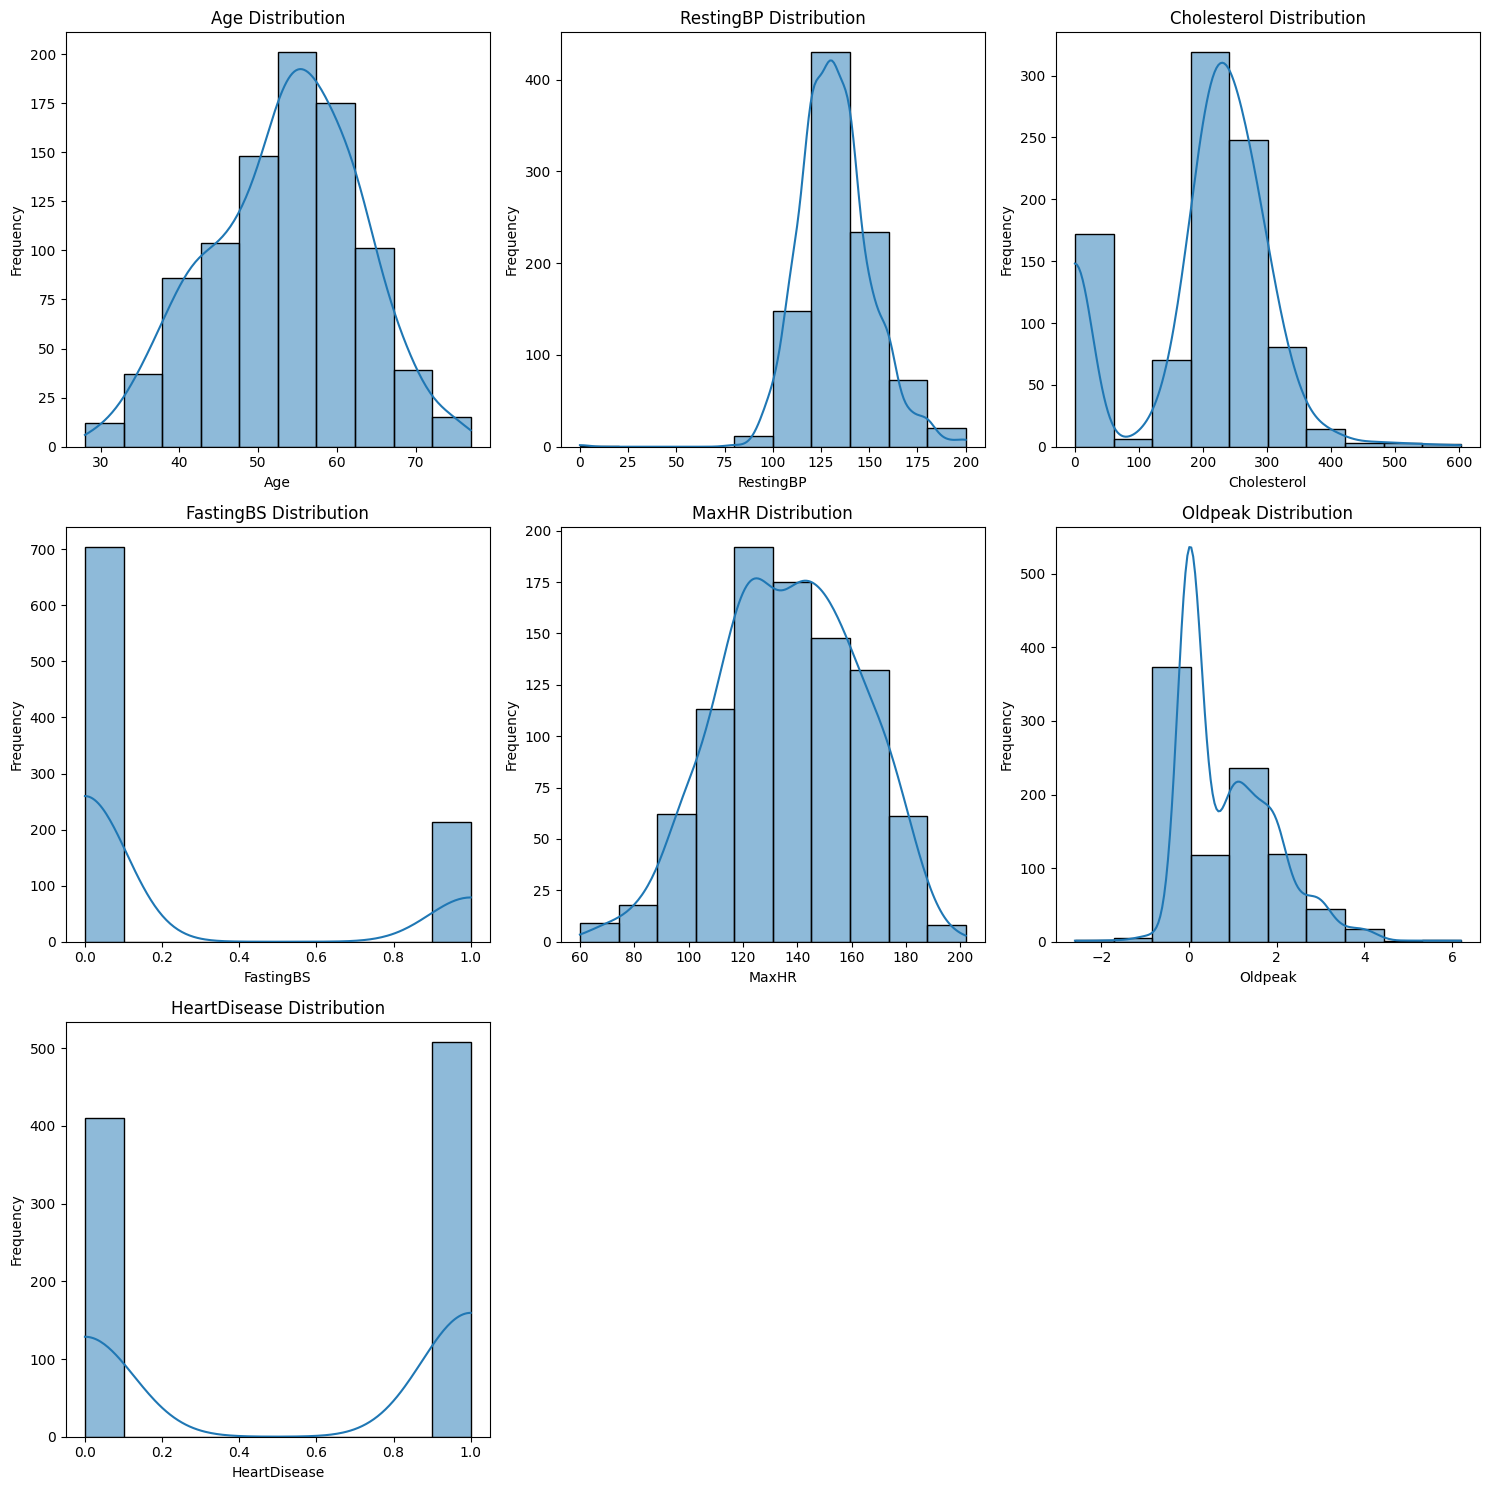

<Figure size 640x480 with 0 Axes>

In [22]:
numeric_features = data.select_dtypes(include=['int', 'float']).columns

fig, axes = plt.subplots(nrows=(len(numeric_features) + 2) // 3, ncols=3, figsize=(15, 5 * ((len(numeric_features) + 2) // 3)))
axes = axes.flatten()
for ax, feature in zip(axes, numeric_features):
    sns.histplot(data[feature], bins=10, kde=True, ax=ax)
    ax.set_title(f'{feature} Distribution')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

for i in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/distribution_plot.png')

## Scatter Plots

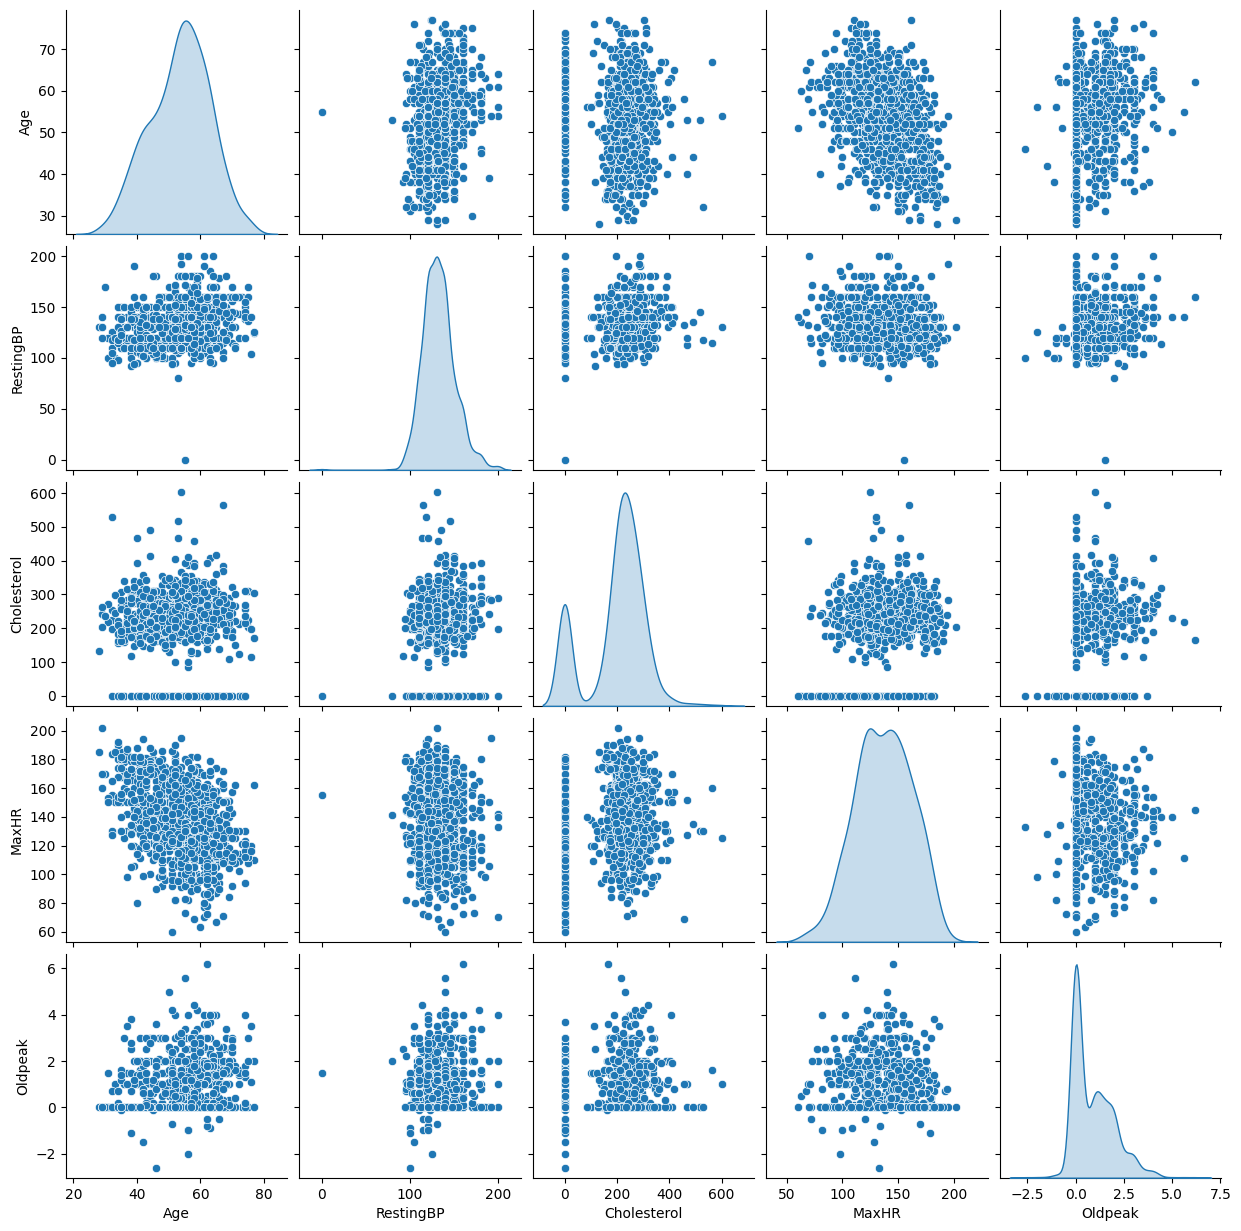

<Figure size 640x480 with 0 Axes>

In [23]:
sns.pairplot(data[numeric_features].drop(columns=['FastingBS','HeartDisease']), diag_kind='kde')  
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/pairplot.png')

## Correlation Matrix

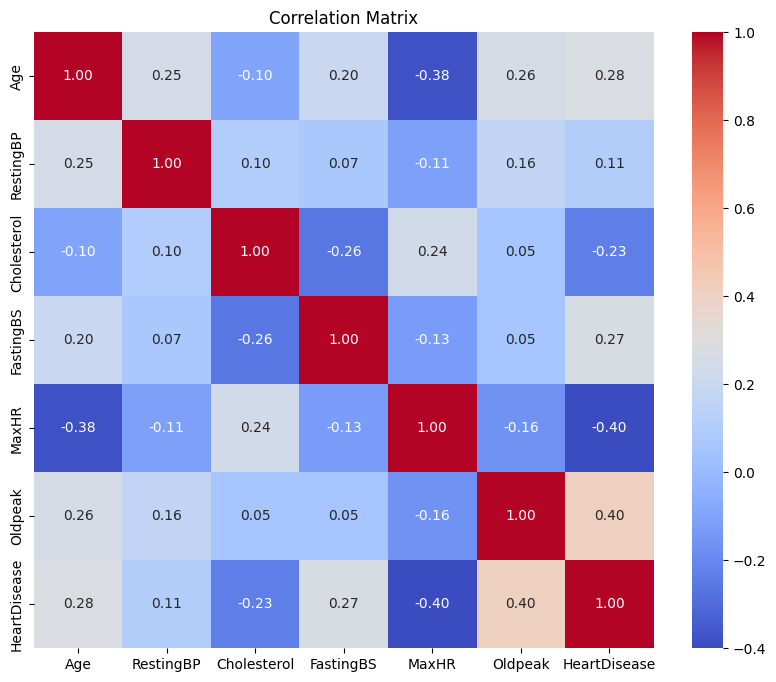

<Figure size 640x480 with 0 Axes>

In [24]:
corr_matrix = data.select_dtypes(['int','float']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=False)
plt.title('Correlation Matrix')
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/correlation_matrix.png')

## IQR

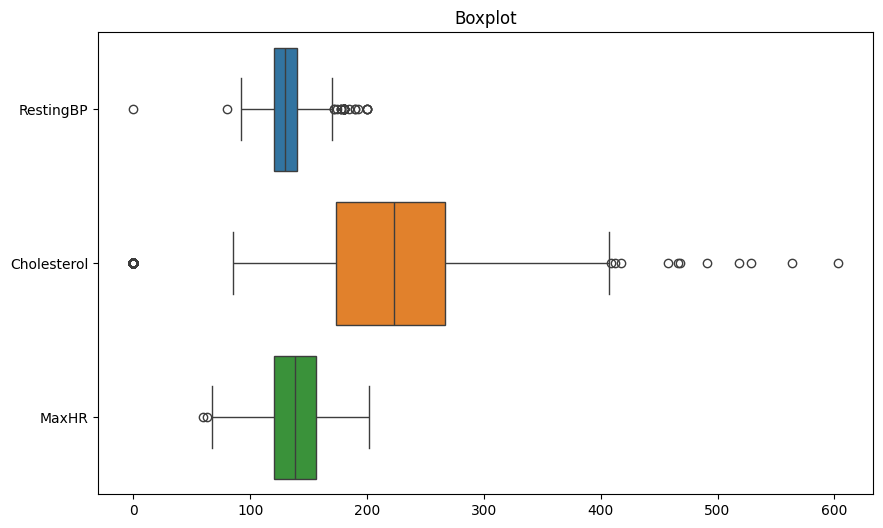

<Figure size 640x480 with 0 Axes>

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data.drop(columns=['Age','Oldpeak','HeartDisease','FastingBS']), orient='h')
plt.title('Boxplot')
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/boxplot.png')

In [26]:
data[data['RestingBP']>180]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
109,39,M,ATA,190,241,0,Normal,106,N,0.0,Up,0
241,54,M,ASY,200,198,0,Normal,142,Y,2.0,Flat,1
365,64,F,ASY,200,0,0,Normal,140,Y,1.0,Flat,1
372,63,M,ASY,185,0,0,Normal,98,Y,0.0,Up,1
399,61,M,NAP,200,0,1,ST,70,N,0.0,Flat,1
592,61,M,ASY,190,287,1,LVH,150,Y,2.0,Down,1
732,56,F,ASY,200,288,1,LVH,133,Y,4.0,Down,1
759,54,M,ATA,192,283,0,LVH,195,N,0.0,Up,1


## Pie Chart Plots

In [27]:
data.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [28]:
def pie_chart(data, column):
    grouped_data=data.groupby(column)
    counts = grouped_data['Age'].count()
    plt.figure(figsize=(8, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.legend(title='Count', labels=[f'{gender}: {count}' for gender, count in counts.items()])
    plt.title('Count of '+' and '.join(data[column].unique().astype(str)))
    plt.show()
    plt.savefig(os.path.join(cfg.HeartFailure.LOGS_PLOTS_PATH,'pie_chart_'+column+'.png'))

In [29]:
def compact_pie_chart(data, column,ax):
    grouped_data = data.groupby(column)
    counts = grouped_data['Age'].count()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.legend(title=f'Count of {column}', labels=[f'{label}: {count}' for label, count in counts.items()], title_fontsize='7', fontsize='5', loc='best')
    ax.set_title('Count of ' + ' and '.join(data[column].unique().astype(str)))

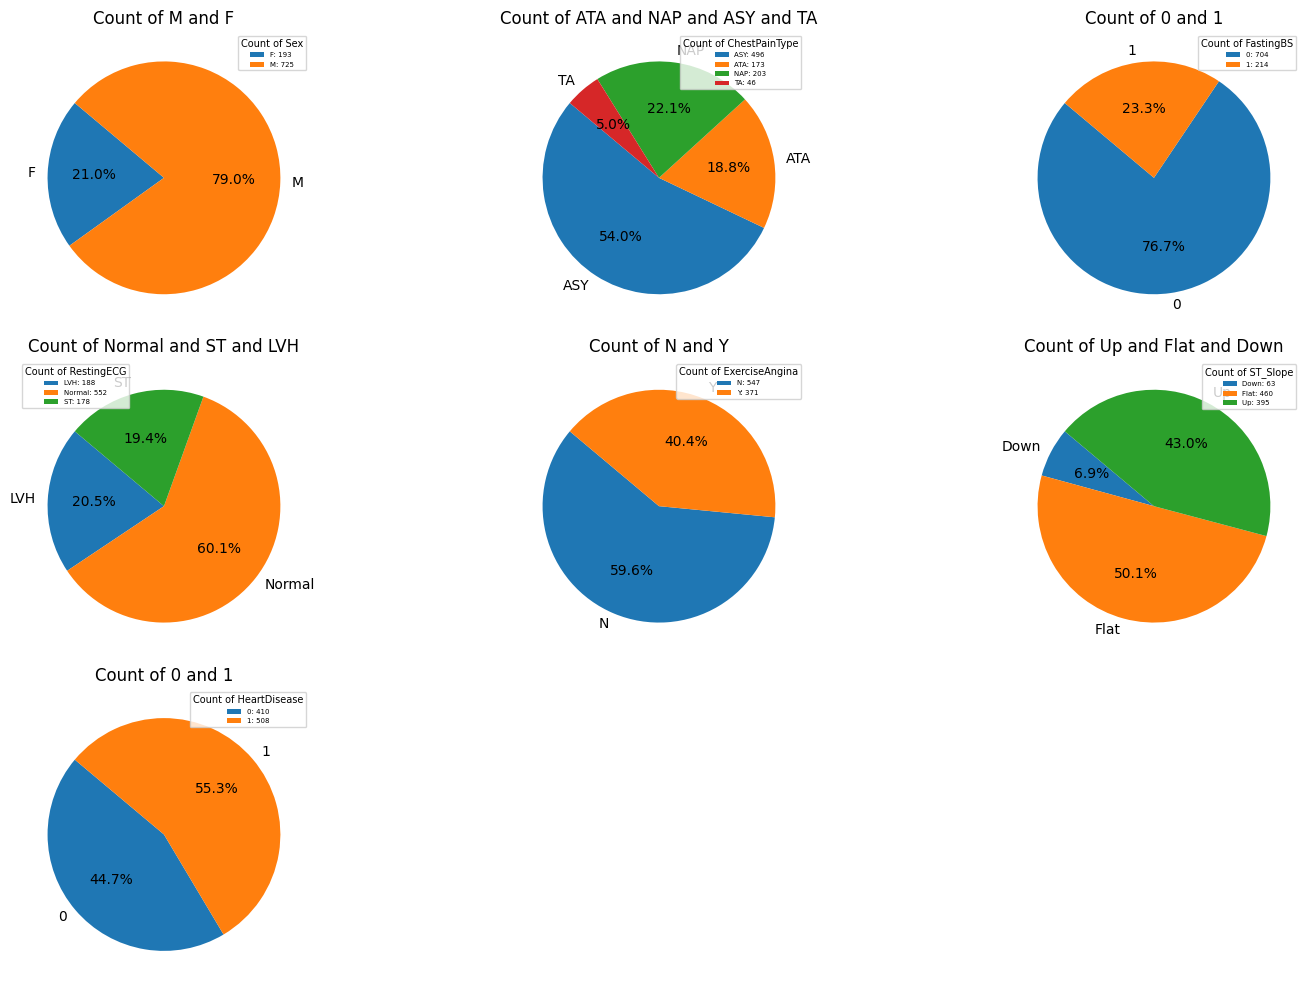

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()
columns = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

for ax, column in zip(axes, columns):
    compact_pie_chart(data, column, ax)
for i in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

### Gender Counts

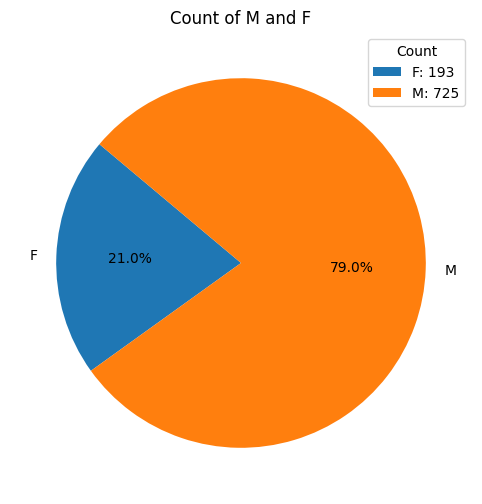

<Figure size 640x480 with 0 Axes>

In [31]:
pie_chart(data,'Sex')

### Chest Pain Types Counts

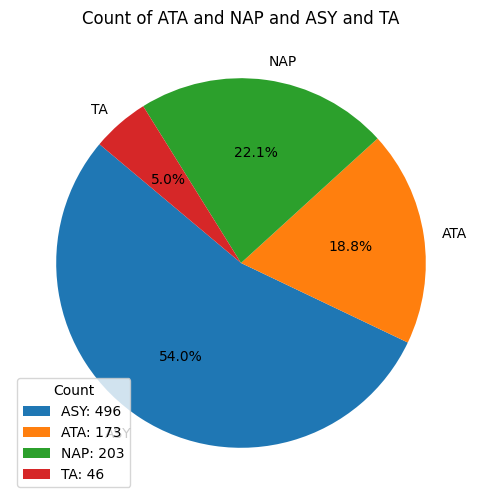

<Figure size 640x480 with 0 Axes>

In [32]:
pie_chart(data,'ChestPainType')

### Fasting BS Counts

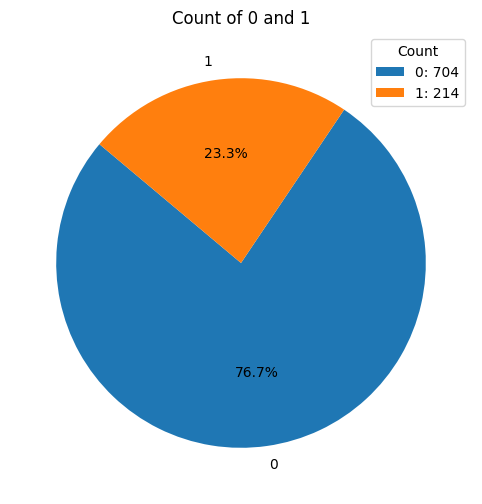

<Figure size 640x480 with 0 Axes>

In [33]:
pie_chart(data,'FastingBS')

### Resting ECG Counts

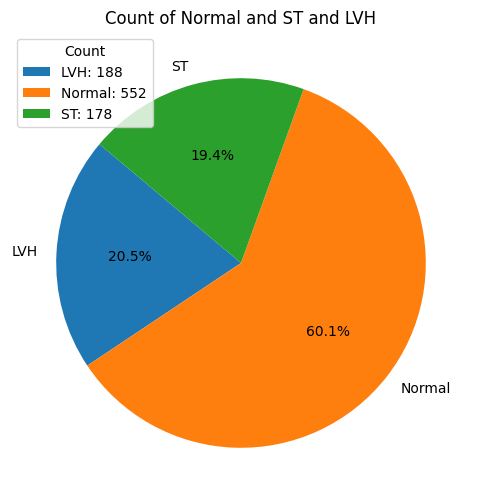

<Figure size 640x480 with 0 Axes>

In [34]:
pie_chart(data,'RestingECG')

### ExerciseAngina Counts

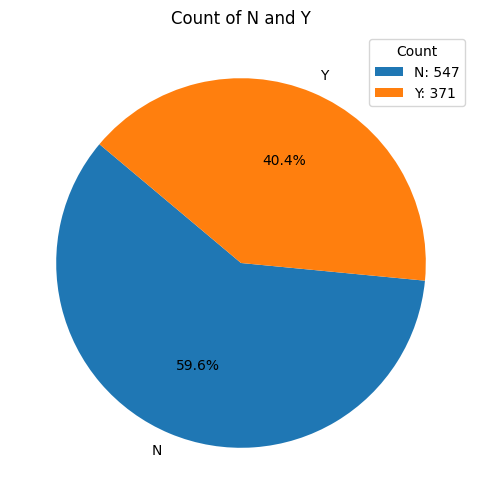

<Figure size 640x480 with 0 Axes>

In [35]:
pie_chart(data,'ExerciseAngina')

### ST Slope Counts

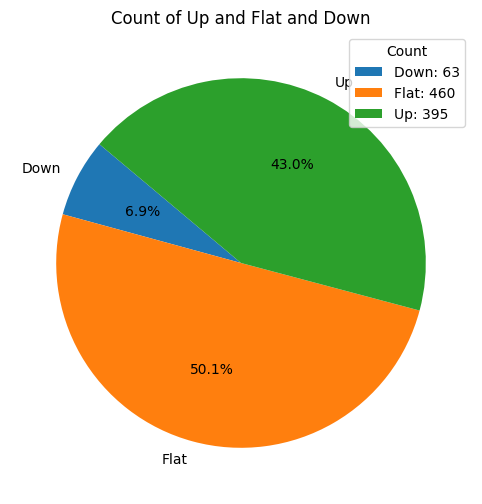

<Figure size 640x480 with 0 Axes>

In [36]:
pie_chart(data,'ST_Slope')

### Heart Disease Counts

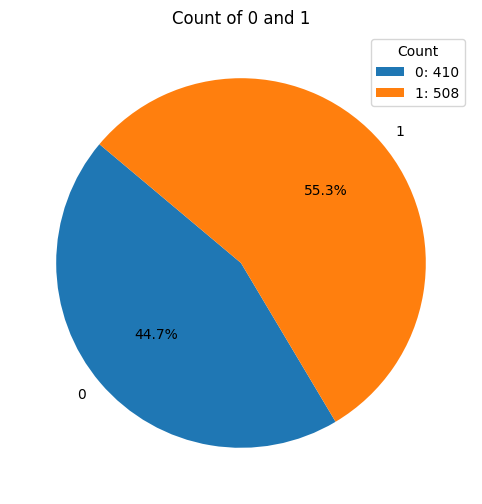

<Figure size 640x480 with 0 Axes>

In [37]:
pie_chart(data,'HeartDisease')

## Swarm Plots

> **could be removed in the future**

In [38]:
# plt.figure(1 , figsize = (15 , 7))
# n = 0 
# for cols in ['RestingBP' , 'Cholesterol' , 'Oldpeak']:
#     n += 1 
#     plt.subplot(1 , 3 , n)
#     plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
#     sns.violinplot(x = cols , y = 'Sex' , data = data , palette = 'vlag')
#     sns.swarmplot(x = cols , y = 'Sex' , data = data)
#     plt.ylabel('Sex' if n == 1 else '')
#     plt.title('Boxplots & Swarmplots' if n == 2 else '')
# plt.show()

# Conclusions

In [39]:
col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',categorical_features)
print('Numerical Features :',numerical_features)

Categorical Features : ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']
Numerical Features : ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


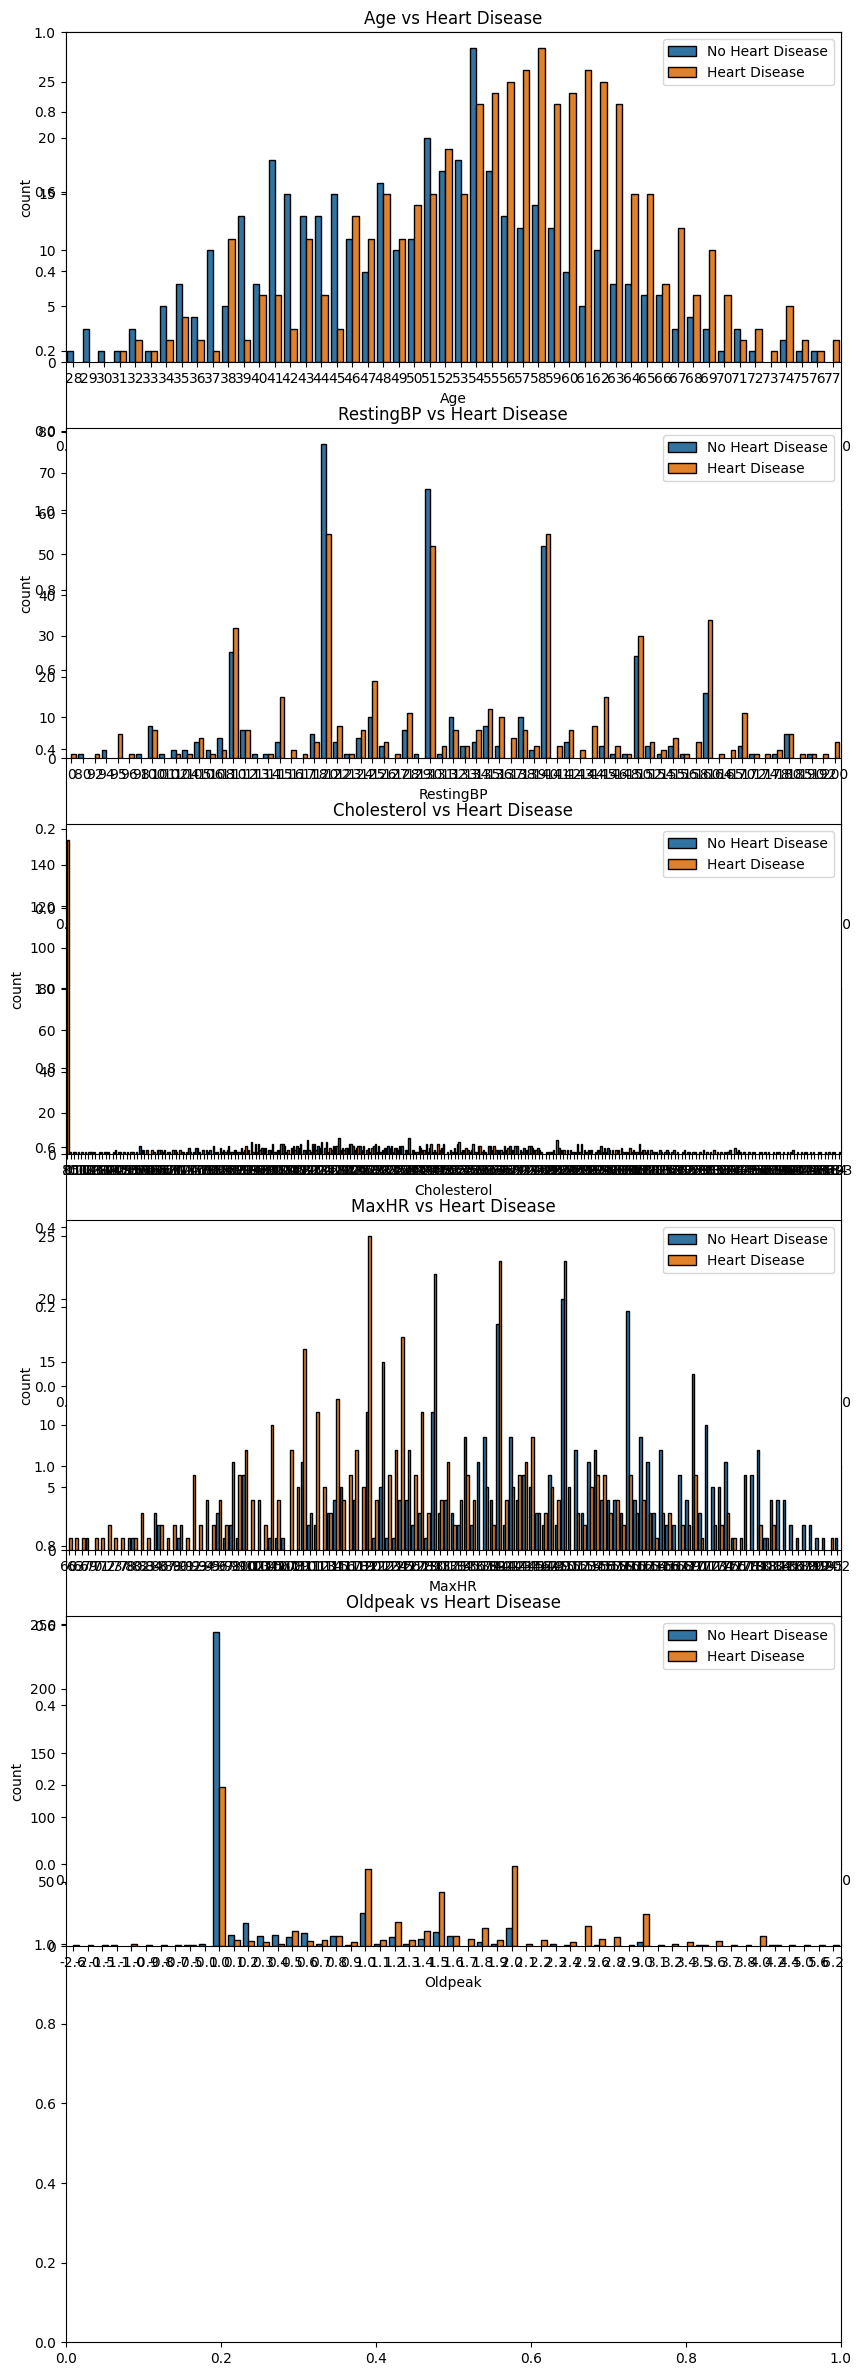

In [40]:
fig, ax = plt.subplots(nrows = 5,ncols = 1,figsize = (10,30))
for i in range(len(numerical_features)):
    plt.subplot(6,1,i+1)
    sns.countplot(x=numerical_features[i], data=data, hue="HeartDisease", edgecolor='black')
    title = numerical_features[i] + ' vs Heart Disease'
    plt.legend(['No Heart Disease','Heart Disease'])
    plt.title(title)

In [41]:

discrete_data = data.copy()

discrete_data['RestingBP_Group'] = [ int(i / 5) for i in discrete_data['RestingBP']]
discrete_data['Cholesterol_Group'] = [ int(i / 10) for i in discrete_data['Cholesterol']]
discrete_data['MaxHR_Group'] = [ int(i / 5) for i in discrete_data['MaxHR']]
discrete_data['Oldpeak_Group'] = [ int((i*10) / 5) for i in discrete_data['Oldpeak']]
discrete_data['Age_Group'] = [ int(i / 10) for i in discrete_data['Age']]


discrete_data.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_Group,Cholesterol_Group,MaxHR_Group,Oldpeak_Group,Age_Group
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,28,28,34,0,4
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,32,18,31,2,4
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,26,28,19,0,3
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,27,21,21,3,4
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,30,19,24,0,5


In [42]:
group_numerical_features = ['Age_Group','RestingBP_Group','Cholesterol_Group','MaxHR_Group','Oldpeak_Group']

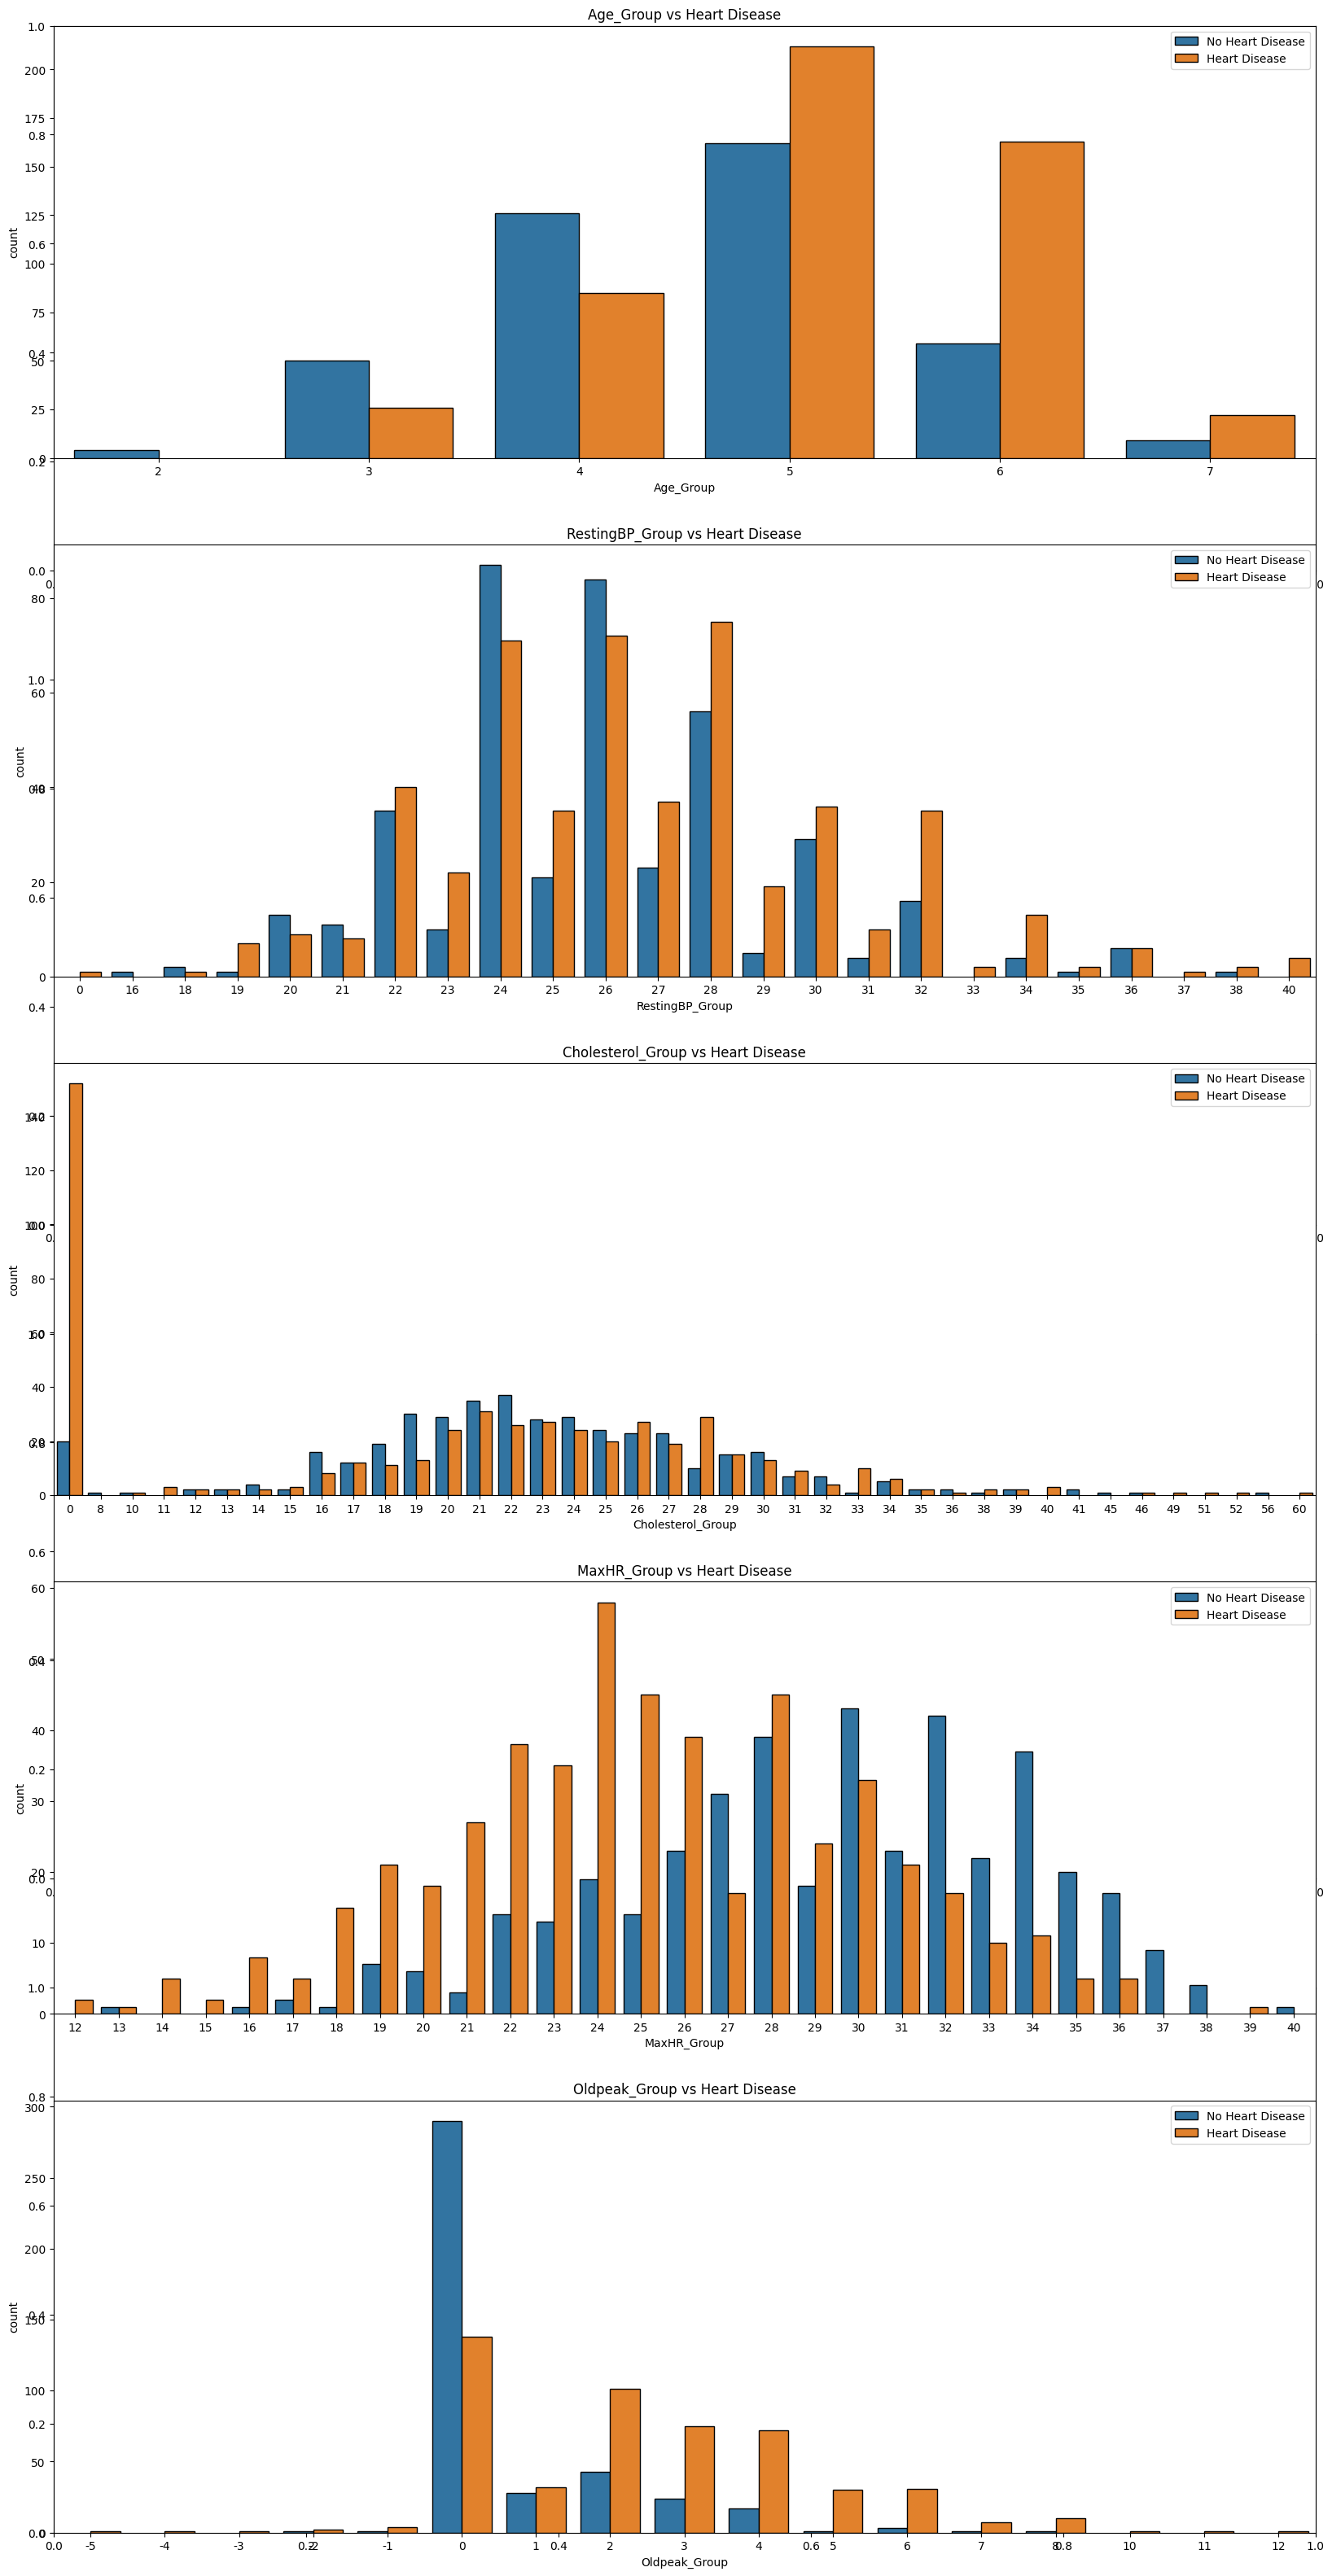

In [43]:
fig, ax = plt.subplots(nrows = 4,ncols = 1,figsize = (20,40))
for i in range(len(group_numerical_features)):
    plt.subplot(5,1,i+1)
    sns.countplot(x=group_numerical_features[i], data=discrete_data, hue="HeartDisease", edgecolor='black')
    title = group_numerical_features[i] + ' vs Heart Disease'
    plt.legend(['No Heart Disease','Heart Disease'])
    plt.title(title)

> <br>
> 
> **🤔 Conclusions:** 
> - people with `age` values between (55-77) are highely compromised to be diagnosed with heart failure.
> - people with `Oldpeak` values between (0.5-6) are highely compromised to be diagnosed with heart failure. 
> - people with `Cholesterol` values between (220-230) and (330-400) are highely compromised to be diagnosed with heart failure. 
> - people with `MaxHR` values between (60-130) and (140-145) are highely compromised to be diagnosed with heart failure. 
> - people with `RestingBP` values between (135-200) are highely compromised to be diagnosed with heart failure. 
> <br>
> <br>

# PCA

In [44]:
def apply_PCA(n_components, data):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    return pca_data, pca

In [45]:
def pca(n_components, data):
    pca_data, pca = apply_PCA(n_components, data)
    print('Explained Variance Ratio :',pca.explained_variance_ratio_)
    print('Explained Variance :',pca.explained_variance_)
    return pca_data

In [46]:
def plot_2d_3d(df):
    """
    Displays either a 2D or 3D scatter plot of features in a DataFrame.
    Prioritizes 3D plotting if sufficient numerical columns exist.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
    """
    
    numeric_columns = df.select_dtypes(include=['number']).columns
    
    if len(numeric_columns) >= 3:
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(
            df[numeric_columns[0]],
            df[numeric_columns[1]],
            df[numeric_columns[2]],
            c='red',
            alpha=0.6
        )
        ax.set_title(f"3D Scatter Plot ({numeric_columns[0]}, {numeric_columns[1]}, {numeric_columns[2]})")
        ax.set_xlabel(numeric_columns[0])
        ax.set_ylabel(numeric_columns[1])
        ax.set_zlabel(numeric_columns[2])
        plt.show()
    elif len(numeric_columns) >= 2:
        # 2D Plot
        plt.figure(figsize=(8, 6))
        plt.scatter(df[numeric_columns[0]], df[numeric_columns[1]], c='blue', alpha=0.6)
        plt.title(f"2D Scatter Plot ({numeric_columns[0]} vs {numeric_columns[1]})")
        plt.xlabel(numeric_columns[0])
        plt.ylabel(numeric_columns[1])
        plt.grid(True)
        plt.show()
    else:
        print("The DataFrame must have at least 2 numerical columns for plotting.")


In [47]:
PCA_1D=PCA(n_components=1)
PCA_2D=PCA(n_components=2)

## PCA 1D

In [48]:
data_encoded = data.copy()
le=LabelEncoder()
for i in cfg.HeartFailure.CATEGORICAL_COLUMNS:
    data_encoded[i]=le.fit_transform(data_encoded[i])

### Raw Data

In [49]:
data_PCA_1D,PCA_1D=apply_PCA(1,data_encoded)

In [50]:
PCA_1D.explained_variance_ratio_

array([0.92020198])

In [51]:
data_PCA_1D = pd.DataFrame(data_PCA_1D, columns=['PCA_F1'])
data_PCA_1D['HeartDisease'] = data_encoded['HeartDisease'].values

In [52]:
data_PCA_1D.head()

,PCA_F1,HeartDisease
0,92.311503,0
1,-17.143183,1
2,81.906031,0
3,13.653713,1
4,-4.347067,0


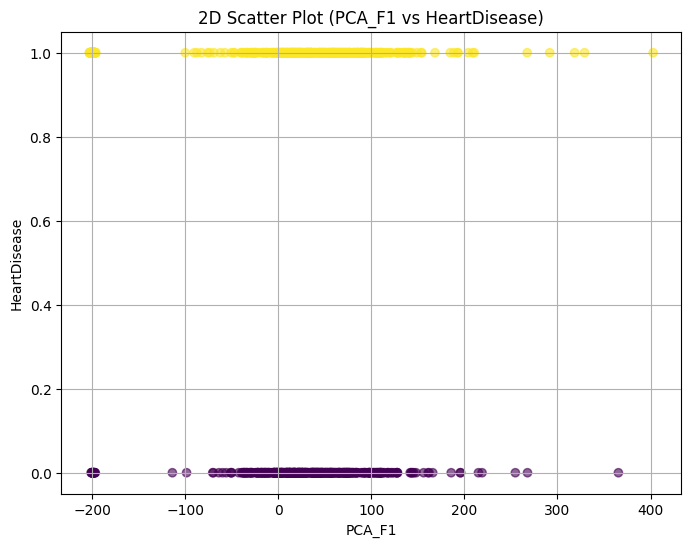

<Figure size 640x480 with 0 Axes>

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(data_PCA_1D['PCA_F1'], data_PCA_1D['HeartDisease'], c=data_PCA_1D['HeartDisease'], cmap='viridis', alpha=0.6)
plt.title("2D Scatter Plot (PCA_F1 vs HeartDisease)")
plt.xlabel('PCA_F1')
plt.ylabel('HeartDisease')
plt.grid(True)
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/2D_Scatter_Plot_PCA_F1_vs_HeartDisease.png')

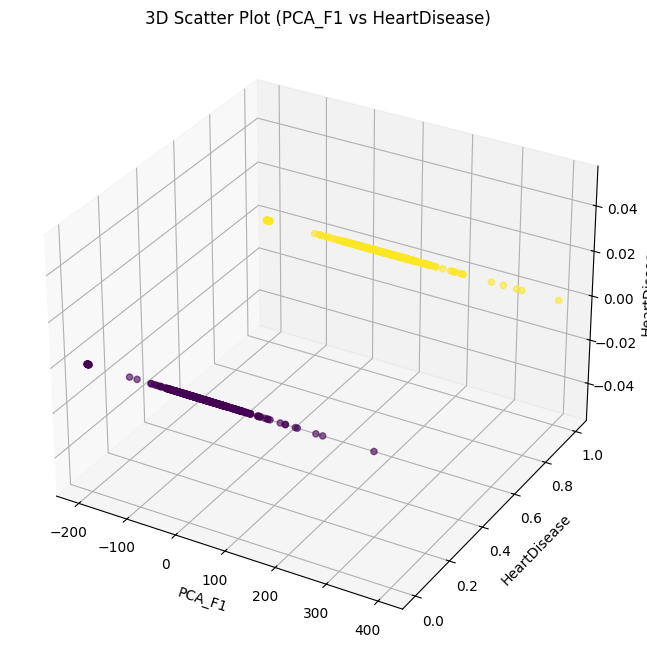

<Figure size 640x480 with 0 Axes>

In [54]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    data_PCA_1D['PCA_F1'],
    data_PCA_1D['HeartDisease'],
    c=data_PCA_1D['HeartDisease'],
    cmap='viridis',
    alpha=0.6
)
ax.set_title("3D Scatter Plot (PCA_F1 vs HeartDisease)")
ax.set_xlabel('PCA_F1')
ax.set_ylabel('HeartDisease')
ax.set_zlabel('HeartDisease')
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/3D_Scatter_Plot_1D_PCA_F1_vs_HeartDisease.png')

## PCA 2D

### Raw data

In [55]:
data_PCA_2D,PCA_2D=apply_PCA(2,data_encoded)

In [56]:
PCA_2D.explained_variance_ratio_

array([0.92020198, 0.04913467])

In [57]:
data_PCA_2D = pd.DataFrame(data_PCA_2D, columns=['PCA_F1','PCA_F2'])
data_PCA_2D['HeartDisease'] = data_encoded['HeartDisease'].values

In [58]:
data_PCA_2D.head()

,PCA_F1,PCA_F2,HeartDisease
0,92.311503,-29.443395,0
1,-17.143183,-13.747713,1
2,81.906031,38.222917,0
3,13.653713,28.752085,1
4,-4.347067,18.081453,0


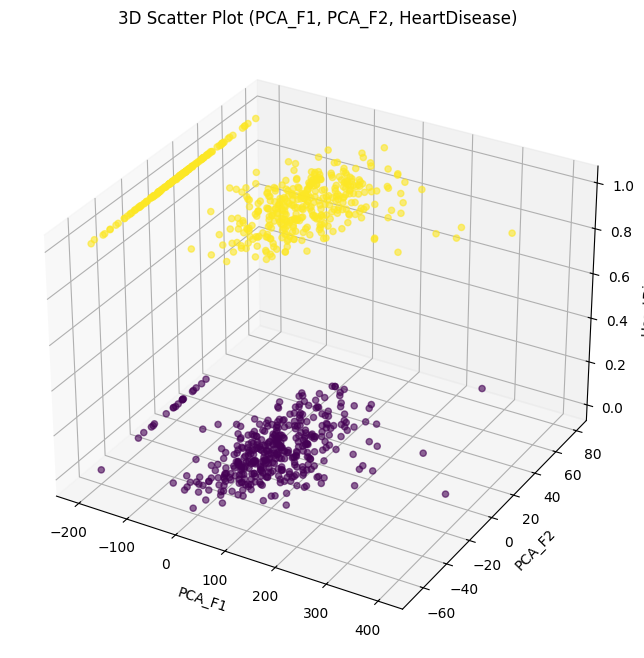

<Figure size 640x480 with 0 Axes>

In [59]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    data_PCA_2D['PCA_F1'],
    data_PCA_2D['PCA_F2'],
    data_PCA_2D['HeartDisease'],
    c=data_PCA_2D['HeartDisease'],
    cmap='viridis',
    alpha=0.6
)
ax.set_title("3D Scatter Plot (PCA_F1, PCA_F2, HeartDisease)")
ax.set_xlabel('PCA_F1')
ax.set_ylabel('PCA_F2')
ax.set_zlabel('HeartDisease')
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/3D_Scatter_Plot_2D_PCA_F1_F2_vs_HeartDisease.png')

# Data Cleaning and Preprocessing

## Missing Values

> <br>
> 
> **💡Note:** *Cholesterol* of a person can never be 0. These 0s will be replaced with median values of the corresponding columns, that's because medians aren't affected by outliers. <br>
> <br>
> 


### Cholesterol

> We will try three methods
> - Dropping rows with cholesterol==0
> - Replacing with mean
> - Replacing with Median
>
> then get the correlation with the target column to see which approach will give the best correlation

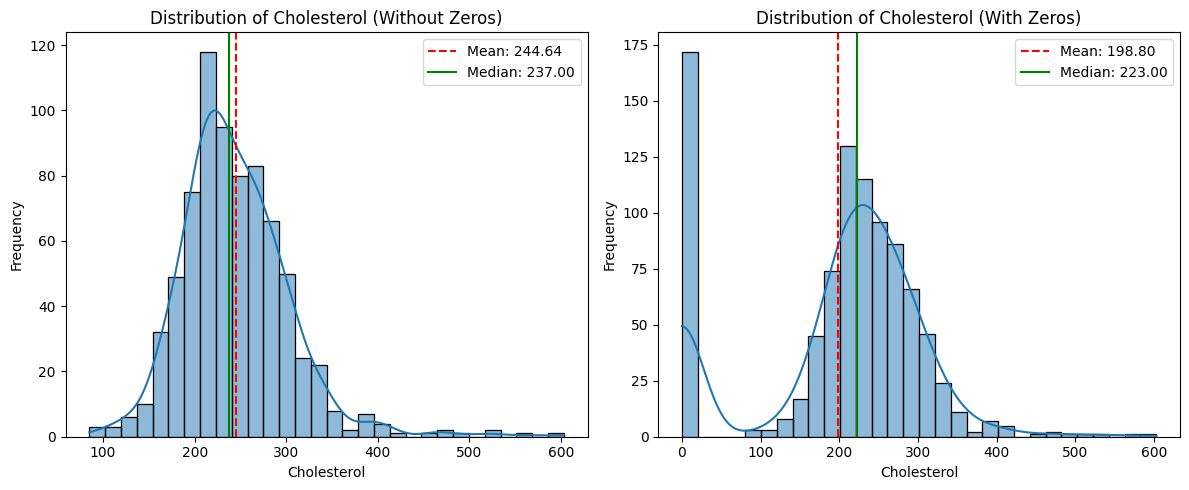

In [60]:
mean_cholesterol = data[data['Cholesterol'] != 0]['Cholesterol'].mean()
median_cholesterol = data[data['Cholesterol'] != 0]['Cholesterol'].median()

mean_cholesterol_with_zeros = data['Cholesterol'].mean()
median_cholesterol_with_zeros = data['Cholesterol'].median()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.histplot(data[data['Cholesterol'] != 0]['Cholesterol'], bins=30, kde=True, ax=axes[0])
axes[0].axvline(mean_cholesterol, color='r', linestyle='--', label=f'Mean: {mean_cholesterol:.2f}')
axes[0].axvline(median_cholesterol, color='g', linestyle='-', label=f'Median: {median_cholesterol:.2f}')
axes[0].set_title('Distribution of Cholesterol (Without Zeros)')
axes[0].set_xlabel('Cholesterol')
axes[0].set_ylabel('Frequency')
axes[0].legend()

sns.histplot(data['Cholesterol'], bins=30, kde=True, ax=axes[1])
axes[1].axvline(mean_cholesterol_with_zeros, color='r', linestyle='--', label=f'Mean: {mean_cholesterol_with_zeros:.2f}')
axes[1].axvline(median_cholesterol_with_zeros, color='g', linestyle='-', label=f'Median: {median_cholesterol_with_zeros:.2f}')
axes[1].set_title('Distribution of Cholesterol (With Zeros)')
axes[1].set_xlabel('Cholesterol')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

In [61]:
print("Cholesterol Mean Value= ",data['Cholesterol'].mean())
print("Cholesterol Median Value= ",data['Cholesterol'].median())

Cholesterol Mean Value=  198.7995642701525
Cholesterol Median Value=  223.0


In [62]:
print("Cholesterol Mean Value without 0s = ",data['Cholesterol'].replace(0, np.nan).dropna().mean())
print("Cholesterol Median Value without 0s = ",data['Cholesterol'].replace(0, np.nan).dropna().median())

Cholesterol Mean Value without 0s =  244.6353887399464
Cholesterol Median Value without 0s =  237.0


> Dropping rows with Cholesterol==0

In [63]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [64]:
data['Cholesterol'].describe()

count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [65]:
data[data['Cholesterol']==0].shape[0]

172

In [66]:
drop_corr = round(data['Cholesterol'].replace(0, np.nan).dropna().corr(data['HeartDisease']),3)
print("Correlation between Cholesterol and HeartDisease after dropping=",drop_corr)

Correlation between Cholesterol and HeartDisease after dropping= 0.104


> Replacing rows with Cholesterol==0 with mean value

In [67]:
mean_corr = round(data['Cholesterol'].replace(0, data[data['Cholesterol']!=0]['Cholesterol'].mean()).corr(data['HeartDisease']),3)
print("Correlation between Cholesterol and HeartDisease after replacing with mean=",mean_corr)

Correlation between Cholesterol and HeartDisease after replacing with mean= 0.094


> Replacing rows with Cholesterol==0 with median value

In [68]:
median_corr = round(data['Cholesterol'].replace(0, data[data['Cholesterol']!=0]['Cholesterol'].median()).corr(data['HeartDisease']),3)
print("Correlation between Cholesterol and HeartDisease after replacing with median=",median_corr)

Correlation between Cholesterol and HeartDisease after replacing with median= 0.076


> **💡Note:** as we see the best correlation appears when dropping the colesterol

> to ensure the results will get the correlation before and after the dropping for each feature and get the difference between them

In [69]:
data_encoded = data.copy()
encoder = LabelEncoder()
for col in data_encoded.columns:
    if data_encoded[col].dtype == 'object':
        data_encoded[col] = encoder.fit_transform(data_encoded[col])

In [70]:
df_before_drop = data_encoded.copy()
df_after_drop = data_encoded.copy()

df_after_drop['Cholesterol'] = df_after_drop['Cholesterol'].replace(0, np.nan)
df_after_drop.dropna(inplace=True)

corr_before = round(df_before_drop.corr().sort_values('HeartDisease',ascending=False).iloc[1:, :]['HeartDisease'],3)
corr_after = round(df_after_drop.corr().sort_values('HeartDisease',ascending=False).iloc[1:, :]['HeartDisease'],3)

In [71]:
difference_df = pd.concat([corr_before, corr_after,(corr_after - corr_before)], axis=1)
difference_df.columns = ['corr_before_drop_0','corr_after_drop_0','difference']
difference_df

,corr_before_drop_0,corr_after_drop_0,difference
ExerciseAngina,0.494,0.552,0.058
Oldpeak,0.404,0.496,0.092
Sex,0.305,0.293,-0.012
Age,0.282,0.299,0.017
FastingBS,0.267,0.161,-0.106
RestingBP,0.108,0.173,0.065
RestingECG,0.057,0.010,-0.047
Cholesterol,-0.233,0.104,0.337
ChestPainType,-0.387,-0.396,-0.009
MaxHR,-0.400,-0.377,0.023


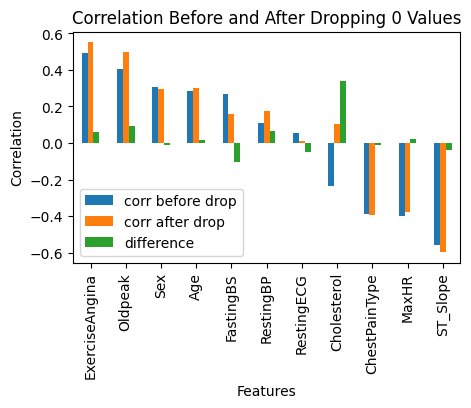

<Figure size 640x480 with 0 Axes>

In [72]:
difference_df = pd.concat([corr_before, corr_after,(corr_after - corr_before)], axis=1)
difference_df.columns = ['corr before drop','corr after drop','difference']
difference_df.plot(kind='bar', figsize=(5, 3))
plt.title('Correlation Before and After Dropping 0 Values')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/correlation_before_after_drop.png')

In [73]:
df_after_mean = data_encoded.copy()

df_after_mean['Cholesterol'] = df_after_mean['Cholesterol'].replace(0, df_after_mean[df_after_mean['Cholesterol']!=0]['Cholesterol'].mean())

corr_before = round(df_before_drop.corr().sort_values('HeartDisease',ascending=False).iloc[1:, :]['HeartDisease'],3)
corr_after = round(df_after_mean.corr().sort_values('HeartDisease',ascending=False).iloc[1:, :]['HeartDisease'],3)

In [74]:
difference_df = pd.concat([corr_before, corr_after,(corr_after - corr_before)], axis=1)
difference_df.columns = ['corr_before_mean_0','corr_after_mean_0','difference']
difference_df

,corr_before_mean_0,corr_after_mean_0,difference
ExerciseAngina,0.494,0.494,0.000
Oldpeak,0.404,0.404,0.000
Sex,0.305,0.305,0.000
Age,0.282,0.282,0.000
FastingBS,0.267,0.267,0.000
RestingBP,0.108,0.108,0.000
RestingECG,0.057,0.057,0.000
Cholesterol,-0.233,0.094,0.327
ChestPainType,-0.387,-0.387,0.000
MaxHR,-0.400,-0.400,0.000


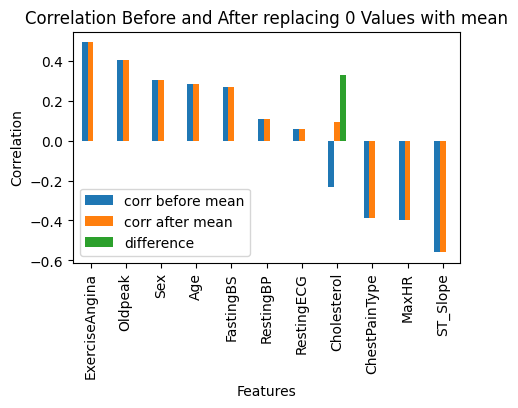

<Figure size 640x480 with 0 Axes>

In [75]:
difference_df = pd.concat([corr_before, corr_after,(corr_after - corr_before)], axis=1)
difference_df.columns = ['corr before mean','corr after mean','difference']
difference_df.plot(kind='bar', figsize=(5, 3))
plt.title('Correlation Before and After replacing 0 Values with mean')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/correlation_before_after_mean.png')

In [76]:
df_after_median = data_encoded.copy()

df_after_median['Cholesterol'] = df_after_median['Cholesterol'].replace(0, df_after_median[df_after_median['Cholesterol']!=0]['Cholesterol'].median())

corr_before = round(df_before_drop.corr().sort_values('HeartDisease',ascending=False).iloc[1:, :]['HeartDisease'],3)
corr_after = round(df_after_median.corr().sort_values('HeartDisease',ascending=False).iloc[1:, :]['HeartDisease'],3)

In [77]:
difference_df = pd.concat([corr_before, corr_after,(corr_after - corr_before)], axis=1)
difference_df.columns = ['corr_before_median_0','corr_after_median_0','difference']
difference_df

,corr_before_median_0,corr_after_median_0,difference
ExerciseAngina,0.494,0.494,0.000
Oldpeak,0.404,0.404,0.000
Sex,0.305,0.305,0.000
Age,0.282,0.282,0.000
FastingBS,0.267,0.267,0.000
RestingBP,0.108,0.108,0.000
RestingECG,0.057,0.057,0.000
Cholesterol,-0.233,0.076,0.309
ChestPainType,-0.387,-0.387,0.000
MaxHR,-0.400,-0.400,0.000


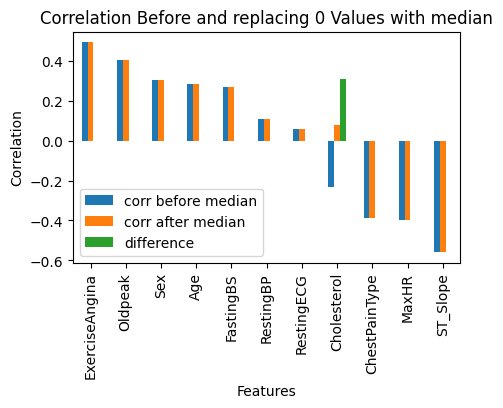

<Figure size 640x480 with 0 Axes>

In [78]:
difference_df = pd.concat([corr_before, corr_after,(corr_after - corr_before)], axis=1)
difference_df.columns = ['corr before median','corr after median','difference']
difference_df.plot(kind='bar', figsize=(5, 3))
plt.title('Correlation Before and replacing 0 Values with median')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/correlation_before_after_median.png')

> **💭Decision:** we decided to replace with `median` values, because it's true that `dropping` them makes better correlation coeff for `Cholesterol` but it affected other features' Correlation<br> <br>
> in addition to that `median` instead of `mean` because medical data like cholesterol often has naturally occurring outliers because of the variance in patient conditions. The `median` value ensures that these valid outliers don't influence the changed values alot.<br> <br>
> the correlation isn't that higher when imputing with mean than with median, regardless that the task is a classification problem, and correlation coeff may not show that much intuition about the resulting output <br> <br>
> the effect of correlation does depend on the type of classifier. Some nonparametric classifiers are less sensitive to correlation of variable.

In [79]:
print("Cholesterol Median Value= ",data['Cholesterol'].median())
print("Cholesterol Median Value without 0s = ",data['Cholesterol'].replace(0, np.nan).dropna().median())

Cholesterol Median Value=  223.0
Cholesterol Median Value without 0s =  237.0


In [80]:
data['Cholesterol'] = data['Cholesterol'].replace(0, data['Cholesterol'].replace(0,np.nan).dropna().median())

In [81]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### RestingBP

> **💡Note:** *Resting Blood Pressure* of a person can never be 0. these 0s will be replaced with median values of the corresponding columns, that's because medians aren't affected by outliers <br>
> <br>

> **🤔Conclusion:** RestingBP can't be zero, so it will be considered as a missing value

In [82]:
data[data['RestingBP']==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,237,0,Normal,155,N,1.5,Flat,1


In [83]:
print("RestingBP Mean Value= ",data['RestingBP'].mean())
print("RestingBP Mean Value without 0s = ",data[data['RestingBP'] != 0]['RestingBP'].mean())
print("RestingBP Median Value= ",data['RestingBP'].median())
print("RestingBP Median Value without 0s = ",data[data['RestingBP'] != 0]['RestingBP'].median())

RestingBP Mean Value=  132.39651416122004
RestingBP Mean Value without 0s =  132.54089422028352
RestingBP Median Value=  130.0
RestingBP Median Value without 0s =  130.0


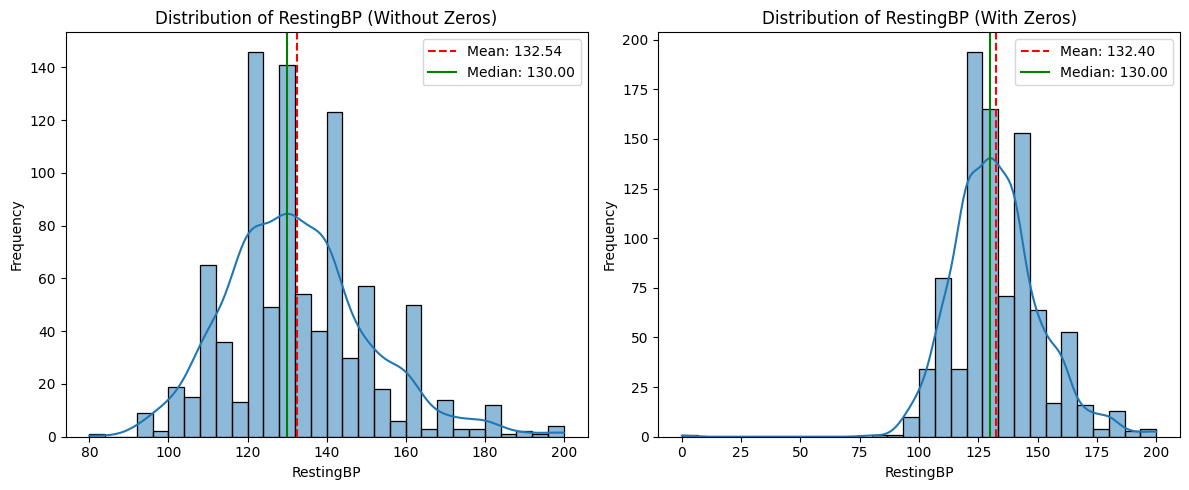

In [84]:
mean_RestingBP = data[data['RestingBP'] != 0]['RestingBP'].mean()
median_RestingBP = data[data['RestingBP'] != 0]['RestingBP'].median()

mean_RestingBP_with_zeros = data['RestingBP'].mean()
median_RestingBP_with_zeros = data['RestingBP'].median()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.histplot(data[data['RestingBP'] != 0]['RestingBP'], bins=30, kde=True, ax=axes[0])
axes[0].axvline(mean_RestingBP, color='r', linestyle='--', label=f'Mean: {mean_RestingBP:.2f}')
axes[0].axvline(median_RestingBP, color='g', linestyle='-', label=f'Median: {median_RestingBP:.2f}')
axes[0].set_title('Distribution of RestingBP (Without Zeros)')
axes[0].set_xlabel('RestingBP')
axes[0].set_ylabel('Frequency')
axes[0].legend()

sns.histplot(data['RestingBP'], bins=30, kde=True, ax=axes[1])
axes[1].axvline(mean_RestingBP_with_zeros, color='r', linestyle='--', label=f'Mean: {mean_RestingBP_with_zeros:.2f}')
axes[1].axvline(median_RestingBP_with_zeros, color='g', linestyle='-', label=f'Median: {median_RestingBP_with_zeros:.2f}')
axes[1].set_title('Distribution of RestingBP (With Zeros)')
axes[1].set_xlabel('RestingBP')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

> **💡Note:** as the `RestingBP` feature is almost normally distributed "after removing zero values" as `mean almost equals median`, we decided to replace them with the median value

In [85]:
data['RestingBP'] = data['RestingBP'].replace(0, data['RestingBP'].replace(0,np.nan).dropna().median())

In [86]:
data[data['RestingBP']==0].shape[0]

0

## Outlier Removal

> **💡Note:** TA could be converted to ATA, it could be a Typo error. "Overthinking" 

### Cholesterol

> **💡Note:** we won't remove any more outliers in Cholesterol column as it's a medical dataset which have a meaning of outliers and it's important to take these values in considiration

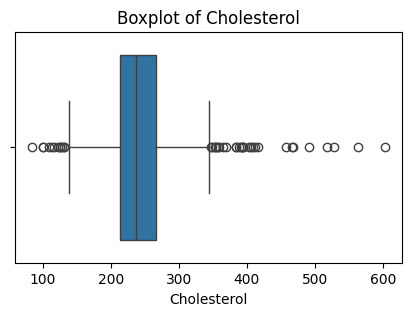

In [87]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=data, x='Cholesterol')
plt.title('Boxplot of Cholesterol')
plt.xlabel('Cholesterol')
plt.show()

### ChestPainType

> **💡Note:** there are few rows with the value of `TA` but after a great search and asking doctors, it was obvious that these values are real and can't be ignored

In [88]:
data[data['ChestPainType']=='TA'].shape[0]

46

In [89]:
data[data['ChestPainType']=='TA']['HeartDisease'].value_counts()

HeartDisease
0    26
1    20
Name: count, dtype: int64

### OldPeak

> **💡Note:** `OldPeak` can't be negative

In [90]:
data['Oldpeak'] = data['Oldpeak'].abs()

### FastingBS

> **💡Note:** FastingBS feature has about 77% of it's values are zeros, so it can be dropped 

In [91]:
print("Percentage of zero values in FastingBS: {:.2f}%".format(data[data['FastingBS'] == 0].shape[0] / data.shape[0] * 100))

Percentage of zero values in FastingBS: 76.69%


In [92]:
data=data.drop(columns=['FastingBS'])

## Duplicates

In [93]:
data.duplicated().sum()

0

> **🤔Conclusion:** There is no duplicated rows in the dataset

## Encoding

In [94]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,Normal,122,N,0.0,Up,0


In [95]:
columns_to_encode=cfg.HeartFailure.CATEGORICAL_COLUMNS

In [96]:
def Encode(data,columns,type='label'):
    data = data.copy()
    if type == 'label':
        encoder = LabelEncoder()
        for col in columns:
            data[col] = encoder.fit_transform(data[col])
    elif type == 'onehot':
        data = pd.get_dummies(data, columns=columns,dtype=int)
    else:
        raise Exception('Invalid Type')
    return data

### Label Encoding

In [97]:
data_label_encoded = Encode(data,columns_to_encode,type='label')

In [98]:
data_label_encoded.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,1,172,0,0.0,2,0
1,49,0,2,160,180,1,156,0,1.0,1,1
2,37,1,1,130,283,2,98,0,0.0,2,0
3,48,0,0,138,214,1,108,1,1.5,1,1
4,54,1,2,150,195,1,122,0,0.0,2,0


### One Hot Encoding

In [99]:
data_onehot_encoded = Encode(data,columns_to_encode,type='onehot')

In [100]:
data_onehot_encoded.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,172,0.0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,49,160,180,156,1.0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,98,0.0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,48,138,214,108,1.5,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,54,150,195,122,0.0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1


## Normalization

In [101]:
string="robust"
# string.startswith("log")
string.endswith("robust")

True

In [102]:
def Scale(data,columns,type='standard'):
    data = data.copy()
    if type.startswith("log"):
        data[columns] = np.log1p(data[columns])
    if type.endswith("standard"):
        scaler = StandardScaler()
        data[columns] = scaler.fit_transform(data[columns])
    elif type.endswith("minmax"):
        scaler = MinMaxScaler()
        data[columns] = scaler.fit_transform(data[columns])
    elif type.endswith("robust"):
        scaler = RobustScaler()
        data[columns] = scaler.fit_transform(data[columns])
    else:
        raise Exception('Invalid Type')
    return data

### MinMax Scaling

In [103]:
data_label_MM_scaled=Scale(data_label_encoded,data_label_encoded.columns.drop('HeartDisease'),type='minmax')

In [104]:
data_label_MM_scaled.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,0.244898,1.0,0.333333,0.500000,0.393822,0.5,0.788732,0.0,0.000000,1.0,0
1,0.428571,0.0,0.666667,0.666667,0.183398,0.5,0.676056,0.0,0.161290,0.5,1
2,0.183673,1.0,0.333333,0.416667,0.382239,1.0,0.267606,0.0,0.000000,1.0,0
3,0.408163,0.0,0.000000,0.483333,0.249035,0.5,0.338028,1.0,0.241935,0.5,1
4,0.530612,1.0,0.666667,0.583333,0.212355,0.5,0.436620,0.0,0.000000,1.0,0


In [105]:
data_onehot_MM_scaled=Scale(data_onehot_encoded,data_onehot_encoded.columns.drop('HeartDisease'),type='minmax')

In [106]:
data_onehot_MM_scaled.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.244898,0.500000,0.393822,0.788732,0.000000,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.428571,0.666667,0.183398,0.676056,0.161290,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.183673,0.416667,0.382239,0.267606,0.000000,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.408163,0.483333,0.249035,0.338028,0.241935,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.530612,0.583333,0.212355,0.436620,0.000000,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


### Standard Scaler

In [107]:
data_label_STD_scaled=Scale(data_label_encoded,data_label_encoded.columns.drop('HeartDisease'),type='standard')

In [108]:
data_label_STD_scaled.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,0.515952,0.229032,0.415002,0.858035,0.017255,1.382928,-0.823556,-0.878238,1.052114,0
1,-0.478484,-1.938163,1.275059,1.527329,-1.184227,0.017255,0.754157,-0.823556,0.081322,-0.596078,1
2,-1.751359,0.515952,0.229032,-0.141161,0.745617,1.601219,-1.525138,-0.823556,-0.878238,1.052114,0
3,-0.584556,-1.938163,-0.816995,0.303769,-0.547191,0.017255,-1.132156,1.214246,0.561102,-0.596078,1
4,0.051881,0.515952,1.275059,0.971166,-0.903182,0.017255,-0.581981,-0.823556,-0.878238,1.052114,0


In [109]:
data_onehot_STD_scaled=Scale(data_onehot_encoded,data_onehot_encoded.columns.drop('HeartDisease'),type='standard')

In [110]:
data_onehot_STD_scaled.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.415002,0.858035,1.382928,-0.878238,0,-0.515952,0.515952,-1.084138,2.075177,-0.532838,-0.229679,-0.507478,0.814275,-0.490449,0.823556,-0.823556,-0.271448,-1.002181,1.150674
1,-0.478484,1.527329,-1.184227,0.754157,0.081322,1,1.938163,-1.938163,-1.084138,-0.481887,1.876744,-0.229679,-0.507478,0.814275,-0.490449,0.823556,-0.823556,-0.271448,0.997824,-0.869056
2,-1.751359,-0.141161,0.745617,-1.525138,-0.878238,0,-0.515952,0.515952,-1.084138,2.075177,-0.532838,-0.229679,-0.507478,-1.228087,2.038947,0.823556,-0.823556,-0.271448,-1.002181,1.150674
3,-0.584556,0.303769,-0.547191,-1.132156,0.561102,1,1.938163,-1.938163,0.922392,-0.481887,-0.532838,-0.229679,-0.507478,0.814275,-0.490449,-1.214246,1.214246,-0.271448,0.997824,-0.869056
4,0.051881,0.971166,-0.903182,-0.581981,-0.878238,0,-0.515952,0.515952,-1.084138,-0.481887,1.876744,-0.229679,-0.507478,0.814275,-0.490449,0.823556,-0.823556,-0.271448,-1.002181,1.150674


> **💡Note:** Possible datasets until now are:
> - data_label_MM_scaled
> - data_onehot_MM_scaled
> - data_label_STD_scaled
> - data_onehot_STD_scaled

### Robust Scaler

In [111]:
data_label_robust_scaled=Scale(data_label_encoded,data_label_encoded.columns.drop('HeartDisease'),type='robust')

In [112]:
data_label_robust_scaled.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.076923,0.0,0.5,0.5,0.981132,0.0,0.944444,0.0,-0.400000,1.0,0
1,-0.384615,-1.0,1.0,1.5,-1.075472,0.0,0.500000,0.0,0.266667,0.0,1
2,-1.307692,0.0,0.5,0.0,0.867925,1.0,-1.111111,0.0,-0.400000,1.0,0
3,-0.461538,-1.0,0.0,0.4,-0.433962,0.0,-0.833333,1.0,0.600000,0.0,1
4,0.000000,0.0,1.0,1.0,-0.792453,0.0,-0.444444,0.0,-0.400000,1.0,0


In [113]:
data_onehot_robust_scaled=Scale(data_onehot_encoded,data_onehot_encoded.columns.drop('HeartDisease'),type='robust')

In [114]:
data_onehot_robust_scaled.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.076923,0.5,0.981132,0.944444,-0.400000,0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
1,-0.384615,1.5,-1.075472,0.500000,0.266667,1,1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.307692,0.0,0.867925,-1.111111,-0.400000,0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,1.0
3,-0.461538,0.4,-0.433962,-0.833333,0.600000,1,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
4,0.000000,1.0,-0.792453,-0.444444,-0.400000,0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0


### Log Normalizer

**💡Note:** After a research, we found a sclaer called Log normalizer that hugely cancels the effect of outliers in the dataset <br>
**💡Note:** Will do it only on `Cholesterol` Column as it has the most outliers

In [115]:
data_label_log_MM_scaled=Scale(data_label_encoded,['Cholesterol'],type='logminmax')

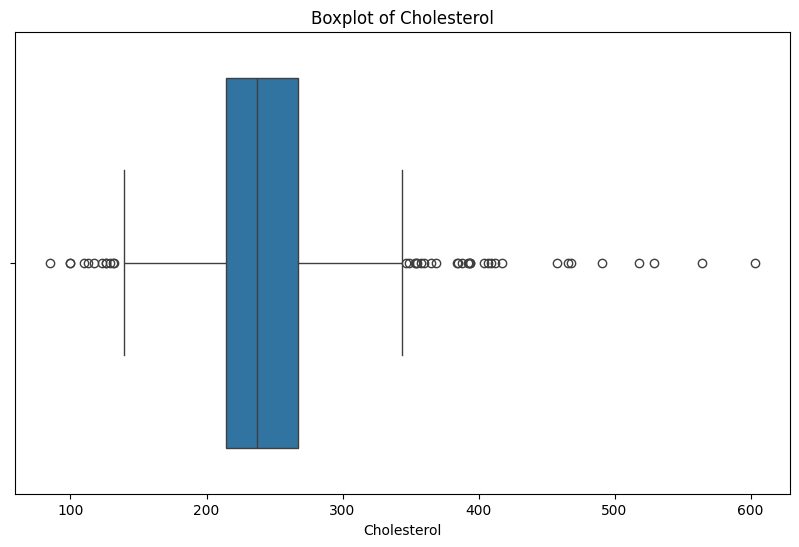

In [116]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Cholesterol')
plt.title('Boxplot of Cholesterol')
plt.xlabel('Cholesterol')
plt.show()

In [117]:
data_label_log_STD_scaled=Scale(data_label_encoded,['Cholesterol'],type='logstandard')

In [118]:
data_label_log_robust_scaled=Scale(data_label_encoded,['Cholesterol'],type='logrobust')

# Splitting

In [119]:
def Split_data(data,target_column,test_size):
    X = data.drop(columns=target_column)
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [120]:
X_train, X_test, y_train, y_test=Split_data(data_label_MM_scaled,'HeartDisease',0.2)

> **💡Note:** Checking the distribution of the training and testing splits as it may affect the accuracy

In [121]:
X_train.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'RestingECG',
       'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

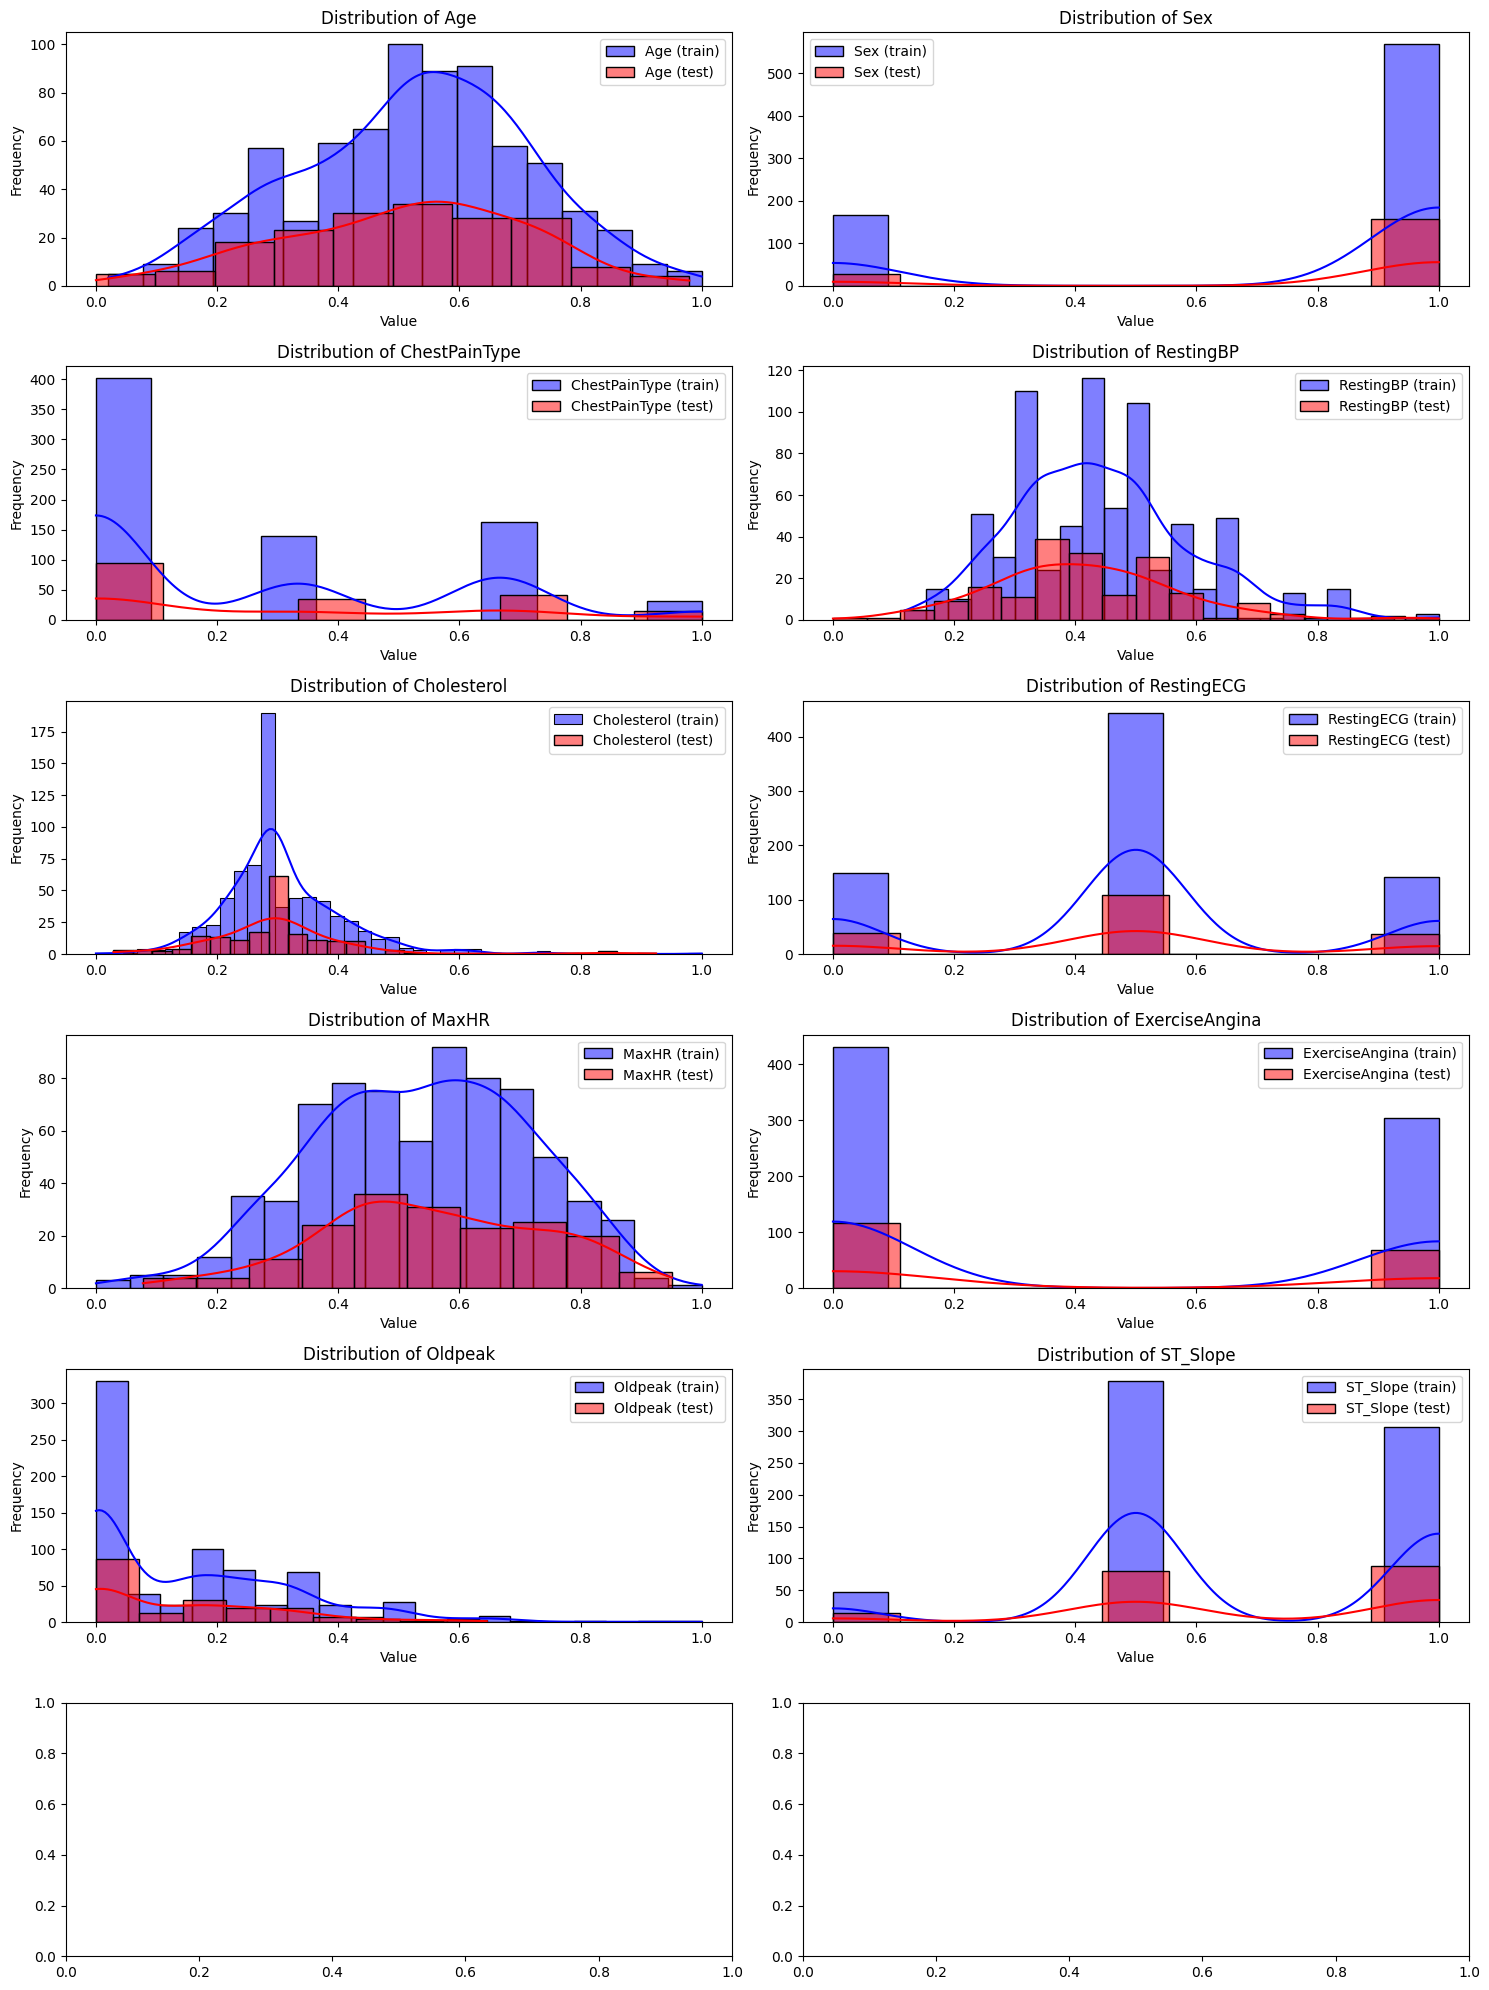

<Figure size 640x480 with 0 Axes>

In [122]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for i, column in enumerate(X_train.columns):
    sns.histplot(X_train[column], kde=True, label=f'{column} (train)', color='blue', alpha=0.5, ax=axes[i])
    sns.histplot(X_test[column], kde=True, label=f'{column} (test)', color='red', alpha=0.5, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()
plt.savefig(cfg.HeartFailure.LOGS_PLOTS_PATH + '/distribution_train_test.png')

# Models

> - GridSearch
>   - label MinMax
>   - label STD
>   - onehot MinMax
>   - onehot STD
> 
> - RandomSearch
>   - label MinMax
>   - label STD
>   - onehot MinMax
>   - onehot STD

In [123]:
def GridSearch(model,parameter_grid,X_train,y_train):
    grid_search = GridSearchCV(model, parameter_grid, cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search

In [124]:
def RandomSearch(model, param_distributions, X_train, y_train, n_iter=100, cv=5):
    random_search = RandomizedSearchCV(model, param_distributions, n_iter=n_iter, cv=cv, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search

## Phase 1

### Naive Bayes

In [125]:
# Code Bayoum

### SVM

In [126]:
params_grid=cfg.HeartFailure.SVM_parameters_grid

In [127]:
params_grid

{'C': [0.01, 0.1, 1, 10, 100],
 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'class_weight': ['balanced', None]}

In [128]:
def SVM_train(X_train, X_test, y_train, y_test, parameter_grid,search_method='Grid'):
    model = SVC()
    if search_method == 'Grid':
        search = GridSearch(model, parameter_grid,X_train, y_train)
    elif search_method == 'Random':
        search = RandomSearch(model, parameter_grid,X_train, y_train)
    else:
        raise Exception('Invalid Search Method')
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1_class0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class1 = f1_score(y_test, y_pred, pos_label=1)
    recall_class0 = recall_score(y_test, y_pred, pos_label=0)
    recall_class1 = recall_score(y_test, y_pred, pos_label=1)
    precision_class0 = precision_score(y_test, y_pred, pos_label=0)
    precision_class1 = precision_score(y_test, y_pred, pos_label=1)

    evaluation={
        "model":best_model,
        "accuracy":accuracy,
        "f1_class0":f1_class0,
        "f1_class1":f1_class1,
        "recall_class0":recall_class0,
        "recall_class1":recall_class1,
        "precision_class0":precision_class0,
        "precision_class1":precision_class1,
        }
    return evaluation

In [129]:
models=['Grid_label_minmax_scaled','Random_label_minmax_scaled','Grid_onehot_minmax_scaled','Random_onehot_minmax_scaled','Grid_label_standard_scaled','Random_label_standard_scaled','Grid_onehot_standard_scaled','Random_onehot_standard_scaled','Grid_label_robust_scaled','Grid_onehot_robust_scaled','Grid_label_logminmax_scaled','Grid_label_logstandard_scaled','Grid_label_logrobust_scaled']

In [130]:
len(models)

13

In [131]:
reports={}
for i in tqdm(models):
    data_encoded = Encode(data, columns_to_encode, type=i.split('_')[1])
    if i.split('_')[2].startswith('log'):
        data_scaled = Scale(data_encoded, ['Cholesterol'], type=i.split('_')[2])
        data_scaled = Scale(data_scaled, data_scaled.columns.drop(['HeartDisease','Cholesterol']), type=i.split('_')[2])
    else:
        data_scaled = Scale(data_encoded, data_encoded.columns.drop('HeartDisease'), type=i.split('_')[2])
    X_train, X_test, y_train, y_test = Split_data(data_scaled, 'HeartDisease', 0.2)
    report = SVM_train(X_train, X_test, y_train, y_test, params_grid, search_method=i.split('_')[0])
    reports[i] = report

100%|██████████| 13/13 [08:40<00:00, 40.01s/it]


In [139]:
for i,model in enumerate(models):
    print(f"Model : {model}  Accuracy : {(reports[model]['accuracy']*100):.2f}%")

Model : Grid_label_minmax_scaled  Accuracy : 80.98%
Model : Random_label_minmax_scaled  Accuracy : 80.98%
Model : Grid_onehot_minmax_scaled  Accuracy : 82.61%
Model : Random_onehot_minmax_scaled  Accuracy : 82.61%
Model : Grid_label_standard_scaled  Accuracy : 84.24%
Model : Random_label_standard_scaled  Accuracy : 84.24%
Model : Grid_onehot_standard_scaled  Accuracy : 84.78%
Model : Random_onehot_standard_scaled  Accuracy : 82.61%
Model : Grid_label_robust_scaled  Accuracy : 85.33%
Model : Grid_onehot_robust_scaled  Accuracy : 82.61%
Model : Grid_label_logminmax_scaled  Accuracy : 81.52%
Model : Grid_label_logstandard_scaled  Accuracy : 85.33%
Model : Grid_label_logrobust_scaled  Accuracy : 84.78%


In [133]:
log_models_to_mlflow(models,reports,"SVM_2")

2024/12/04 05:27:21 INFO mlflow.tracking.fluent: Experiment with name 'SVM_2' does not exist. Creating a new experiment.


2024/12/04 05:27:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/12/04 05:27:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run Grid_label_minmax_scaled at: http://127.0.0.1:5000/#/experiments/366404944552349714/runs/1f7411c658da44c0b1d9d39c02c7c76f.
2024/12/04 05:27:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/366404944552349714.
2024/12/04 05:27:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/12/04 05:27:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random_label_minmax_scaled at: http://127.0.0.1:5000/#/experiments/366404944552349714/runs/f3af3a47109043a7a5f0bfd0db0c3a94.
2024/12/04 05:27:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/

## Phase 2

### Decision Trees

In [134]:
# Code Mohamed Yasser

### KNN

## Extra Models

### MLP

### Logistion Regression

### XGBoost